In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.colors as mcolors
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [2]:
# filepath = "C:/Users/dutts/OneDrive - Johns Hopkins/Documents/"
# chartpath = "C:/Users/dutts/OneDrive - Johns Hopkins/Documents/plots/charts/"
filepath = "/Users/sdutta/OneDrive - Johns Hopkins/Documents/"
chartpath = "/Users/sdutta/OneDrive - Johns Hopkins/Documents/plots/charts/"

In [3]:
dk = xr.open_dataset(filepath + "kostadinov/kostadinov_composite_variable_fill.nc")
dc = xr.open_dataset(filepath + "copernicus/2010-2023_cmems_bgc_plankton_variable_fill.nc")
dm = xr.open_dataset(filepath + "modis/2002_2023_modis_variable_fill.nc")

In [4]:
dfk = dk.to_dataframe()
dfk = dfk.astype("float32")
kosta = dfk.dropna()
kosta.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 431112 entries, (np.float64(-77.5), np.uint64(1), np.float64(-178.5)) to (np.float64(83.5), np.uint64(12), np.float64(-22.5))
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   dfe      431112 non-null  float32
 1   mld      431112 non-null  float32
 2   nh4      431112 non-null  float32
 3   no3      431112 non-null  float32
 4   po4      431112 non-null  float32
 5   rsn      431112 non-null  float32
 6   sst      431112 non-null  float32
 7   sal      431112 non-null  float32
 8   w50      431112 non-null  float32
 9   sil      431112 non-null  float32
 10  logphyc  431112 non-null  float32
 11  phyc     431112 non-null  float32
 12  mcro     431112 non-null  float32
 13  nano     431112 non-null  float32
 14  pico     431112 non-null  float32
 15  logmcro  431112 non-null  float32
 16  lognano  431112 non-null  float32
 17  logpico  431112 non-null  float32
dtypes: flo

In [5]:
dfc = dc.to_dataframe()
dfc = dfc.astype("float32")
coper = dfc.dropna()
coper.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 430620 entries, (np.float64(-77.5), np.uint64(1), np.float64(-178.5)) to (np.float64(82.5), np.uint64(12), np.float64(81.5))
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   dfe      430620 non-null  float32
 1   mld      430620 non-null  float32
 2   nh4      430620 non-null  float32
 3   no3      430620 non-null  float32
 4   po4      430620 non-null  float32
 5   rsn      430620 non-null  float32
 6   sst      430620 non-null  float32
 7   sal      430620 non-null  float32
 8   w50      430620 non-null  float32
 9   sil      430620 non-null  float32
 10  chla     430620 non-null  float32
 11  diat     430620 non-null  float32
 12  mcro     430620 non-null  float32
 13  nano     430620 non-null  float32
 14  pico     430620 non-null  float32
 15  logchla  430620 non-null  float32
 16  logdiat  430620 non-null  float32
 17  logmcro  430620 non-null  float32
 18  lognano

In [6]:
dfm = dm.to_dataframe()
dfm = dfm.astype("float32")
modis = dfm.dropna()
modis.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 430380 entries, (np.float64(-77.5), np.uint64(1), np.float64(-178.5)) to (np.float64(83.5), np.uint64(12), np.float64(-22.5))
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   dfe      430380 non-null  float32
 1   mld      430380 non-null  float32
 2   nh4      430380 non-null  float32
 3   no3      430380 non-null  float32
 4   po4      430380 non-null  float32
 5   rsn      430380 non-null  float32
 6   sst      430380 non-null  float32
 7   sal      430380 non-null  float32
 8   w50      430380 non-null  float32
 9   sil      430380 non-null  float32
 10  chla     430380 non-null  float32
 11  logchla  430380 non-null  float32
 12  mcro     430380 non-null  float32
 13  nano     430380 non-null  float32
 14  pico     430380 non-null  float32
 15  logmcro  430380 non-null  float32
 16  lognano  430380 non-null  float32
 17  logpico  430380 non-null  float32
dtypes: flo

In [7]:
# kosta = pd.read_csv("C:/Users/dutts/OneDrive - Johns Hopkins/Documents/kostadinov/kostadinov_monthly_mean_composite_dataset.csv", index_col=['month','lat','lon'])
# coper = pd.read_csv("C:/Users/dutts/OneDrive - Johns Hopkins/Documents/copernicus/2017-2021_clim_cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M.csv",index_col=['month','lat','lon'])
# modis = pd.read_csv("C:/Users/dutts/OneDrive - Johns Hopkins/Documents/modis/AQUA_MODIS.clim.2002_2023.L3m.MC.CHL.x_chlor_a.csv", index_col=['month','lat','lon'])

### Random Forest

In [8]:
# kosta = kosta.quantile(q=np.arange(0,1,0.01))
# coper = coper.quantile(q=np.arange(0,1,0.01))
# modis = modis.quantile(q=np.arange(0,1,0.01))

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, TransformerMixin

class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range

    def fit(self, X, y=None):
        X = self._validate_input(X)
        self.data_min_ = np.min(X, axis=0)
        self.data_max_ = np.max(X, axis=0)
        self.scale_ = (self.feature_range[1] - self.feature_range[0]) / (self.data_max_ - self.data_min_)
        self.min_ = self.feature_range[0] - self.data_min_ * self.scale_
        return self

    def transform(self, X):
        X = self._validate_input(X)
        return X * self.scale_ + self.min_

    def inverse_transform(self, X_scaled):
        X_scaled = self._validate_input(X_scaled)
        return (X_scaled - self.min_) / self.scale_

    def _validate_input(self, X):
        if isinstance(X, pd.DataFrame):
            return X.values
        elif isinstance(X, np.ndarray):
            return X
        else:
            raise ValueError("Input must be a pandas DataFrame or NumPy array.")

In [10]:
mcolors.TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

In [11]:
blue=mcolors.TABLEAU_COLORS['tab:blue']
orange=mcolors.TABLEAU_COLORS['tab:orange']
green=mcolors.TABLEAU_COLORS['tab:green']
red=mcolors.TABLEAU_COLORS['tab:red']
purple=mcolors.TABLEAU_COLORS['tab:purple']
brown=mcolors.TABLEAU_COLORS['tab:brown']
pink=mcolors.TABLEAU_COLORS['tab:pink']
olive=mcolors.TABLEAU_COLORS['tab:olive']
cyan=mcolors.TABLEAU_COLORS['tab:cyan']
gray=mcolors.TABLEAU_COLORS['tab:gray']

In [12]:
my_colors={'dfe':brown,'mld':olive, 'nh4':purple,'no3':pink, 'po4':cyan, 'rsn':orange,
           'sal':green, 'sst':red, 'sil':blue, 'w50':gray}

#### Random Forest Kostadinov

In [13]:
# kosta = shuffle(kosta)
# kosta = kosta.iloc[:10000]
# kosta.loc[:,'logdfe'] = np.log10(kosta['dfe'])
# Xk = kosta.drop(['dfe','mcro','nano','pico','phyc','logmcro','lognano','logpico','logphyc'], axis=1)
Xk = kosta.drop(['mcro','nano','pico','phyc','logmcro','lognano','logpico','logphyc'], axis=1)
# Xk = Xk.loc[:, ['logdfe','mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50']]
Xk = Xk.loc[:, ['dfe','mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50']]
# Xk = kosta.drop(['cmicro','cnano','cpico','phyc','logmcro','lognano','logpico','logphyc'], axis=1)
ykphyc = kosta['logphyc']
ykmcro = kosta['logmcro']
yknano = kosta['lognano']
ykpico = kosta['logpico']

In [14]:
Xk.head()

dfe        mld       nh4       no3       po4  \
lat   month lon                                                             
-77.5 1     -178.5  2.679019e-07  77.747002  0.000551  0.016134  0.001235   
            -177.5  2.644416e-07  75.447998  0.000523  0.016679  0.001251   
            -176.5  2.960231e-07  73.435997  0.000496  0.017200  0.001268   
            -175.5  2.617441e-07  71.829002  0.000470  0.017657  0.001283   
            -174.5  3.002942e-07  70.742996  0.000440  0.018044  0.001296   

                           rsn        sal      sst       sil           w50  
lat   month lon                                                             
-77.5 1     -178.5  130.119232  34.274502 -0.25111  0.058165  8.775279e-07  
            -177.5  125.292305  34.261688 -0.30951  0.057787  7.140983e-07  
            -176.5  127.242310  34.249710 -0.36131  0.057461  1.770336e-07  
            -175.5  127.242310  34.238689 -0.40501  0.057123 -5.363125e-07  
            -174.5  121.280769  34.228912 -0.44010  0.056761 -1.706607e-06

In [15]:
Xk_train, Xk_test, ykphyc_train, ykphyc_test = train_test_split(Xk, ykphyc, test_size=0.2, shuffle=True, random_state=101)

In [16]:
kosta_phyc = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [17]:
kosta_phyc.fit(Xk_train, ykphyc_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [18]:
# filename = "rfphyc_kostadinov.joblib"
# joblib.dump(kosta_phyc, filename)
# kosta_phyc = joblib.load(filename)

In [19]:
ykphyc_test_pred = kosta_phyc.predict(Xk_test.to_numpy())
re = np.sqrt(mean_squared_error(ykphyc_test, ykphyc_test_pred))
r2 = r2_score(ykphyc_test,ykphyc_test_pred)
rn = re / ykphyc_test.std()
print("RMSE phyc     : ",re)
print("Norm RMSE phyc: ",rn)
print("R2 Score phyc : ",r2)

RMSE phyc     :  0.11369247256549847
Norm RMSE phyc:  0.3495254411354028
R2 Score phyc :  0.8778305467283188


Reference scores  
RMSE phyc:  0.11565631449027938  
Normalised RMSE phyc:  0.3546560387344827  
R2 Score phyc:  0.874218364787711

In [20]:
Xk_train, Xk_test, ykmcro_train, ykmcro_test = train_test_split(Xk, ykmcro, test_size=0.2, shuffle=True, random_state=101)

In [21]:
kosta_mcro = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [22]:
kosta_mcro.fit(Xk_train, ykmcro_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [23]:
# filename = "rfmcro_kostadinov.joblib"
# joblib.dump(kosta_mcro, filename)
# kosta_mcro = joblib.load(filename)

In [24]:
ykmcro_test_pred = kosta_mcro.predict(Xk_test.to_numpy())
re = np.sqrt(mean_squared_error(ykmcro_test, ykmcro_test_pred))
r2 = r2_score(ykmcro_test,ykmcro_test_pred)
rn = re / ykmcro_test.std()
print("RMSE micro     : ", re)
print("Norm RMSE micro: ",rn)
print("R2 Score micro : ",r2)

RMSE micro     :  0.21776416085601927
Norm RMSE micro:  0.28868089115622364
R2 Score micro :  0.9166623747322568


Reference values  
RMSE:  0.25656060951601983  
Normalised RMSE:  0.2945367249892131  
R2 Score:  0.9132476145598218

In [25]:
Xk_train, Xk_test, yknano_train, yknano_test = train_test_split(Xk, yknano, test_size=0.2, shuffle=True, random_state=101)

In [26]:
kosta_nano = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [27]:
kosta_nano.fit(Xk_train, yknano_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [28]:
# filename = "rfnano_kostadinov.joblib"
# joblib.dump(kosta_nano, filename)
# kosta_nano = joblib.load(filename)

In [29]:
yknano_test_pred = kosta_nano.predict(Xk_test.to_numpy())
re = np.sqrt(mean_squared_error(yknano_test, yknano_test_pred))
r2 = r2_score(yknano_test,yknano_test_pred)
rn = re / yknano_test.std()
print("RMSE nano     : ", re)
print("Norm RMSE nano: ",rn)
print("R2 Score nano : ",r2)

RMSE nano     :  0.12758037755336407
Norm RMSE nano:  0.26419020561949924
R2 Score nano :  0.9302027206565084


Reference values  
RMSE : 0.15242339372630892  
Normalised RMSE:  0.28000871581736214  
R2 Score : 0.9215946643976406

In [30]:
Xk_train, Xk_test, ykpico_train, ykpico_test = train_test_split(Xk, ykpico, test_size=0.2, shuffle=True, random_state=101)

In [31]:
kosta_pico = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [32]:
kosta_pico.fit(Xk_train, ykpico_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [33]:
# filename = "rfpico_kostadinov.joblib"
# joblib.dump(kosta_pico, filename)
# kosta_pico = joblib.load(filename)

In [34]:
ykpico_test_pred = kosta_pico.predict(Xk_test.to_numpy())
re = np.sqrt(mean_squared_error(ykpico_test, ykpico_test_pred))
r2 = r2_score(ykpico_test,ykpico_test_pred)
rn = re / ykpico_test.std()
print("RMSE pico     : ", re)
print("Norm RMSE pico: ",rn)
print("R2 Score pico : ",r2)

RMSE pico     :  0.07534000203164233
Norm RMSE pico:  0.2681222008467945
R2 Score pico :  0.9281096558961671


Reference Values   
RMSE : 0.047544904111293286  
Normalised RMSE:  0.2961349881061683  
R2 Score : 0.912303560272036

#### Random Forest Copernicus

In [35]:
# coper = shuffle(coper)
# coper = coper.iloc[:10000]
# coper.loc[:,'logdfe'] = np.log10(coper['dfe'])
# Xc = coper.drop(['dfe','chla','diat','mcro','nano','pico','logchla','logdiat','logmcro','lognano','logpico'], axis=1)
# Xc = Xc.loc[:, ['logdfe','mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50']]
Xc = coper.drop(['chla','diat','mcro','nano','pico','logchla','logdiat','logmcro','lognano','logpico'], axis=1)
Xc = Xc.loc[:, ['dfe','mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50']]
# Xc = coper.drop(['chla','diat','dino','mcro','nano','pico','logchla','logdiat','logmcro','lognano','logpico'], axis=1)
ycchla = coper['logchla']
ycmcro = coper['logmcro']
ycnano = coper['lognano']
ycpico = coper['logpico']

In [36]:
Xc.head()

dfe        mld       nh4       no3       po4  \
lat   month lon                                                             
-77.5 1     -178.5  2.679019e-07  77.747002  0.000551  0.016134  0.001235   
            -177.5  2.644416e-07  75.447998  0.000523  0.016679  0.001251   
            -176.5  2.960231e-07  73.435997  0.000496  0.017200  0.001268   
            -175.5  2.617441e-07  71.829002  0.000470  0.017657  0.001283   
            -174.5  3.002942e-07  70.742996  0.000440  0.018044  0.001296   

                           rsn        sal      sst       sil           w50  
lat   month lon                                                             
-77.5 1     -178.5  130.119232  34.274502 -0.25111  0.058165  8.775279e-07  
            -177.5  125.292305  34.261688 -0.30951  0.057787  7.140983e-07  
            -176.5  127.242310  34.249710 -0.36131  0.057461  1.770336e-07  
            -175.5  127.242310  34.238689 -0.40501  0.057123 -5.363125e-07  
            -174.5  121.280769  34.228912 -0.44010  0.056761 -1.706607e-06

In [37]:
Xc_train, Xc_test, ycchla_train, ycchla_test = train_test_split(Xc, ycchla, test_size=0.2, shuffle=True, random_state=101)

In [38]:
coper_chla = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [39]:
coper_chla.fit(Xc_train, ycchla_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [40]:
# filename = "rfchla_copernicus.joblib"
# joblib.dump(coper_chla, filename)
# coper_chla = joblib.load(filename)

In [41]:
ycchla_test_pred = coper_chla.predict(Xc_test.to_numpy())
re = np.sqrt(mean_squared_error(ycchla_test, ycchla_test_pred))
r2 = r2_score(ycchla_test,ycchla_test_pred)
rn = re / ycchla_test.std()
print("RMSE chla     : ", re)
print("Norm RMSE chla: ",rn)
print("R2 Score chla : ",r2)

RMSE chla     :  0.10672049125374382
Norm RMSE chla:  0.28225653440766973
R2 Score chla :  0.9203303312737825


RMSE:  0.10753190472663597  
Normalized RMSE:  0.281222857266973  

R2 Score:  0.92091324593043  63

In [42]:
Xc_train, Xc_test, ycmcro_train, ycmcro_test = train_test_split(Xc, ycmcro, test_size=0.2, shuffle=True, random_state=101)

In [43]:
coper_mcro = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [44]:
coper_mcro.fit(Xc_train, ycmcro_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [45]:
# filename = "rfmcro_copernicus.joblib"
# joblib.dump(coper_mcro, filename)
# coper_mcro = joblib.load(filename)

In [46]:
ycmcro_test_pred = coper_mcro.predict(Xc_test.to_numpy())
re = np.sqrt(mean_squared_error(ycmcro_test, ycmcro_test_pred))
r2 = r2_score(ycmcro_test,ycmcro_test_pred)
rn = re / ycmcro_test.std()
print("RMSE micro     : ", re)
print("Norm RMSE micro: ",rn)
print("R2 Score micro : ",r2)

RMSE micro     :  0.1219040850100815
Norm RMSE micro:  0.22946713085260279
R2 Score micro :  0.9473442312658247


RMSE : 0.15998159875517007  
Normalised RMSE: 0.317352856052321  

R2 Score : 0.8992865807233124

In [47]:
Xc_train, Xc_test, ycnano_train, ycnano_test = train_test_split(Xc, ycnano, test_size=0.2, shuffle=True, random_state=101)

In [48]:
coper_nano = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [49]:
coper_nano.fit(Xc_train, ycnano_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [50]:
# filename = "rfnano_copernicus.joblib"
# joblib.dump(coper_nano, filename)
# coper_nano = joblib.load(filename)

In [51]:
ycnano_test_pred = coper_nano.predict(Xc_test.to_numpy())
re = np.sqrt(mean_squared_error(ycnano_test, ycnano_test_pred))
r2 = r2_score(ycnano_test,ycnano_test_pred)
rn = re / ycnano_test.std()
print("RMSE nano     : ", re)
print("Norm RMSE nano: ",rn)
print("R2 Score nano : ",r2)

RMSE nano     :  0.09960343643651538
Norm RMSE nano:  0.28305079816088685
R2 Score nano :  0.9198813114381834


RMSE : 0.138577588011663  
Normalised RMSE: 0.3250834078528443  

R2 Score : 0.89432016510666  15

In [52]:
Xc_train, Xc_test, ycpico_train, ycpico_test = train_test_split(Xc, ycpico, test_size=0.2, shuffle=True, random_state=101)

In [53]:
coper_pico = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [54]:
coper_pico.fit(Xc_train, ycpico_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [55]:
# filename = "rfpico_copernicus.joblib"
# joblib.dump(coper_pico, filename)
# coper_pico = joblib.load(filename)

In [56]:
ycpico_test_pred = coper_pico.predict(Xc_test.to_numpy())
re = np.sqrt(mean_squared_error(ycpico_test, ycpico_test_pred))
r2 = r2_score(ycpico_test,ycpico_test_pred)
rn = re / ycpico_test.std()
print("RMSE pico     : ", re)
print("Norm RMSE pico: ",rn)
print("R2 Score pico : ",r2)

RMSE pico     :  0.10424720413096315
Norm RMSE pico:  0.3347327651546744
R2 Score pico :  0.8879526638986511


RMSE : 0.09125346088571347  
Normalised RMSE: 0.3197280460855604 

R2 Score : 0.8977733837392335

#### Random Forest MODIS

In [57]:
# modis = shuffle(modis)
# modis = modis.iloc[:10000]
# modis.loc[:, 'logdfe'] = np.log10(modis['dfe'])
# Xh = modis.drop(['dfe','chla','mcro','nano','pico','logchla','logmcro','lognano','logpico'], axis=1)
# Xh = Xh.loc[:, ['logdfe','mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50']]
# Xh = modis.drop(['chla','mcro','nano','pico','logchla','logmcro','lognano','logpico'], axis=1)
Xh = modis.drop(['chla','mcro','nano','pico','logchla','logmcro','lognano','logpico'], axis=1)
Xh = Xh.loc[:, ['dfe','mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50']]
yhchla = modis['logchla']
yhmcro = modis['logmcro']
yhnano = modis['lognano']
yhpico = modis['logpico']

In [58]:
Xh.head()

dfe        mld       nh4       no3       po4  \
lat   month lon                                                             
-77.5 1     -178.5  2.679019e-07  77.747002  0.000551  0.016134  0.001235   
            -177.5  2.644416e-07  75.447998  0.000523  0.016679  0.001251   
            -176.5  2.960231e-07  73.435997  0.000496  0.017200  0.001268   
            -175.5  2.617441e-07  71.829002  0.000470  0.017657  0.001283   
            -174.5  3.002942e-07  70.742996  0.000440  0.018044  0.001296   

                           rsn        sal      sst       sil           w50  
lat   month lon                                                             
-77.5 1     -178.5  130.119232  34.274502 -0.25111  0.058165  8.775279e-07  
            -177.5  125.292305  34.261688 -0.30951  0.057787  7.140983e-07  
            -176.5  127.242310  34.249710 -0.36131  0.057461  1.770336e-07  
            -175.5  127.242310  34.238689 -0.40501  0.057123 -5.363125e-07  
            -174.5  121.280769  34.228912 -0.44010  0.056761 -1.706607e-06

In [59]:
Xh_train, Xh_test, yhchla_train, yhchla_test = train_test_split(Xh, yhchla, test_size=0.2, shuffle=True, random_state=101)

In [60]:
modis_chla = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [61]:
modis_chla.fit(Xh_train, yhchla_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [62]:
# filename = "rfchla_modis.joblib"
# joblib.dump(modis_chla, filename)
# modis_chla = joblib.load(filename)

In [63]:
yhchla_test_pred = modis_chla.predict(Xh_test.to_numpy())
re = np.sqrt(mean_squared_error(yhchla_test, yhchla_test_pred))
r2 = r2_score(yhchla_test,yhchla_test_pred)
rn = re / yhchla_test.std()
print("RMSE chla     : ", re)
print("Norm RMSE chla: ",rn)
print("R2 Score chla : ",r2)

RMSE chla     :  0.11556733420998001
Norm RMSE chla:  0.2691844806903125
R2 Score chla :  0.9275388701196088


In [64]:
Xh_train, Xh_test, yhmcro_train, yhmcro_test = train_test_split(Xh, yhmcro, test_size=0.2, shuffle=True, random_state=101)

In [65]:
modis_mcro = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [66]:
modis_mcro.fit(Xh_train, yhmcro_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [67]:
# filename = "rfmcro_modis.joblib"
# joblib.dump(modis_mcro, filename)
# modis_mcro = joblib.load(filename)

In [68]:
yhmcro_test_pred = modis_mcro.predict(Xh_test.to_numpy())
re = np.sqrt(mean_squared_error(yhmcro_test, yhmcro_test_pred))
r2 = r2_score(yhmcro_test,yhmcro_test_pred)
rn = re / yhmcro_test.std()
print("RMSE micro     : ", re)
print("Norm RMSE micro: ",rn)
print("R2 Score micro : ",r2)

RMSE micro     :  0.2193183650978372
Norm RMSE micro:  0.2707243468099323
R2 Score micro :  0.9267074828757431


In [69]:
Xh_train, Xh_test, yhnano_train, yhnano_test = train_test_split(Xh, yhnano, test_size=0.2, shuffle=True, random_state=101)

In [70]:
modis_nano = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [71]:
modis_nano.fit(Xh_train, yhnano_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [72]:
# filename = "rfnano_modis.joblib"
# joblib.dump(modis_nano, filename)
# modis_nano = joblib.load(filename)

In [73]:
yhnano_test_pred = modis_nano.predict(Xh_test.to_numpy())
re = np.sqrt(mean_squared_error(yhnano_test, yhnano_test_pred))
r2 = r2_score(yhnano_test,yhnano_test_pred)
rn = re / yhnano_test.std()
print("RMSE nano     : ", re)
print("Norm RMSE nano: ",rn)
print("R2 Score nano : ",r2)

RMSE nano     :  0.12217008479475178
Norm RMSE nano:  0.23820570968120522
R2 Score nano :  0.9432573758693321


In [74]:
Xh_train, Xh_test, yhpico_train, yhpico_test = train_test_split(Xh, yhpico, test_size=0.2, shuffle=True, random_state=101)

In [75]:
Xh_train

,,,dfe,mld,nh4,no3,po4,rsn,sal,sst,sil,w50
lat,month,lon,,,,,,,,,,
-16.5,9,117.5,4.909948e-07,32.777000,0.000042,3.459000e-07,0.000046,268.307404,34.476501,25.855810,0.002042,-8.255108e-07
-0.5,6,68.5,7.401826e-07,53.224998,0.000025,2.480935e-04,0.000174,208.815384,35.202202,29.446301,0.005741,7.116282e-07
54.5,7,-19.5,4.038909e-07,35.054001,0.000225,2.588254e-03,0.000259,174.055557,35.319313,13.594090,0.000945,3.254576e-07
45.5,10,-141.5,3.370878e-07,41.588001,0.000116,2.940001e-03,0.000625,86.911110,32.663212,13.963710,0.000837,4.628889e-08
35.5,8,151.5,6.000986e-07,18.551001,0.000012,6.398639e-05,0.000139,224.277771,34.244701,26.098991,0.008982,2.911578e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
16.5,2,-30.5,1.568211e-06,75.524002,0.000195,5.622485e-05,0.000102,205.661545,36.411087,22.912701,0.000190,-1.022794e-06
-38.5,12,123.5,1.819283e-07,40.653999,0.000359,1.747847e-03,0.000333,254.011108,35.112598,15.290791,0.003102,-1.277467e-06
-18.5,11,-113.5,8.223338e-08,54.800999,0.000148,7.952832e-04,0.000284,288.799988,36.367912,24.185400,0.001333,-1.838669e-06


In [76]:
modis_pico = Pipeline(steps = [
    ('scaler', CustomMinMaxScaler(feature_range=(0,10))),
    ('rf', RandomForestRegressor(n_estimators=50, bootstrap=True, max_features="sqrt", min_samples_leaf=5, random_state=101))
     ])

In [77]:
modis_pico.fit(Xh_train, yhpico_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0


In [78]:
# filename = "rfpico_modis.joblib"
# joblib.dump(modis_pico, filename)
# modis_pico = joblib.load(filename)

In [79]:
yhpico_test_pred = modis_pico.predict(Xh_test.to_numpy())
re = np.sqrt(mean_squared_error(yhpico_test, yhpico_test_pred))
r2 = r2_score(yhpico_test,yhpico_test_pred)
rn = re / yhpico_test.std()
print("RMSE pico     : ",re)
print("Norm RMSE pico: ",rn)
print("R2 Score pico : ",r2)

RMSE pico     :  0.0876020930990087
Norm RMSE pico:  0.2614333317663628
R2 Score pico :  0.9316518247402917


### Permutation Importance from Scratch

In [112]:
from sklearn.metrics import root_mean_squared_error

def permutation_importance(model, X, y, metric=root_mean_squared_error, n_repeats=10, random_state=42):
    """
    Compute permutation importance for each feature with multiple shuffles.

    Parameters:
    - model: trained model with .predict() method
    - X: pd.DataFrame, test features
    - y: pd.Series or np.ndarray, true labels
    - metric: scoring function (default: mean_squared_error)
    - squared: bool, if False use RMSE instead of MSE
    - n_repeats: number of times to permute each feature
    - random_state: int or None, controls reproducibility of shuffling

    Returns:
    - pd.DataFrame with mean importance and standard deviation
    """
    rng = np.random.default_rng(random_state)

    # baseline score
    baseline_score = metric(y, model.predict(X))

    results = []
    for feature in X.columns:
        # diffs = []
        pi = []
        for _ in range(n_repeats):
            X_copy = X.copy()
            
            # shuffle feature
            X_copy[feature] = rng.permutation(X_copy[feature].values)
            
            # new score
            perm_score = metric(y, model.predict(X_copy))
            pi.append(perm_score)
            
            # # difference from baseline
            # diffs.append(perm_score - baseline_score)
        
        # results.append({
        #     "feature": feature,
        #     "importance_mean": np.mean(diffs),
        #     "importance_std": np.std(diffs)
        # })

        # If we do not want to take the difference but rather the actual permuted RMSE
        results.append({
            "Inputs": feature,
            "rmse": np.mean(pi),
            "norm_rmse": np.mean(pi) / y.std(),
            "std_dev": np.std(pi)
        })

    df = pd.DataFrame(results)
    # print(df)

    # return pd.DataFrame(results).sort_values(by="rmse", ascending=False).reset_index(drop=True)
    return df

In [113]:
pi_kostaphyc = permutation_importance(kosta_phyc, Xk, ykphyc)
pi_coperchla = permutation_importance(coper_chla, Xc, ycchla)
pi_modischla = permutation_importance(modis_chla, Xh, yhchla)

In [114]:
pi_kostamcro = permutation_importance(kosta_mcro, Xk, ykmcro)
pi_copermcro = permutation_importance(coper_mcro, Xc, ycmcro)
pi_modismcro = permutation_importance(modis_mcro, Xh, yhmcro)

In [115]:
pi_kostanano = permutation_importance(kosta_nano, Xk, yknano)
pi_copernano = permutation_importance(coper_nano, Xc, ycnano)
pi_modisnano = permutation_importance(modis_nano, Xh, yhnano)

In [116]:
pi_kostapico = permutation_importance(kosta_pico, Xk, ykpico)
pi_coperpico = permutation_importance(coper_pico, Xc, ycpico)
pi_modispico = permutation_importance(modis_pico, Xh, yhpico)

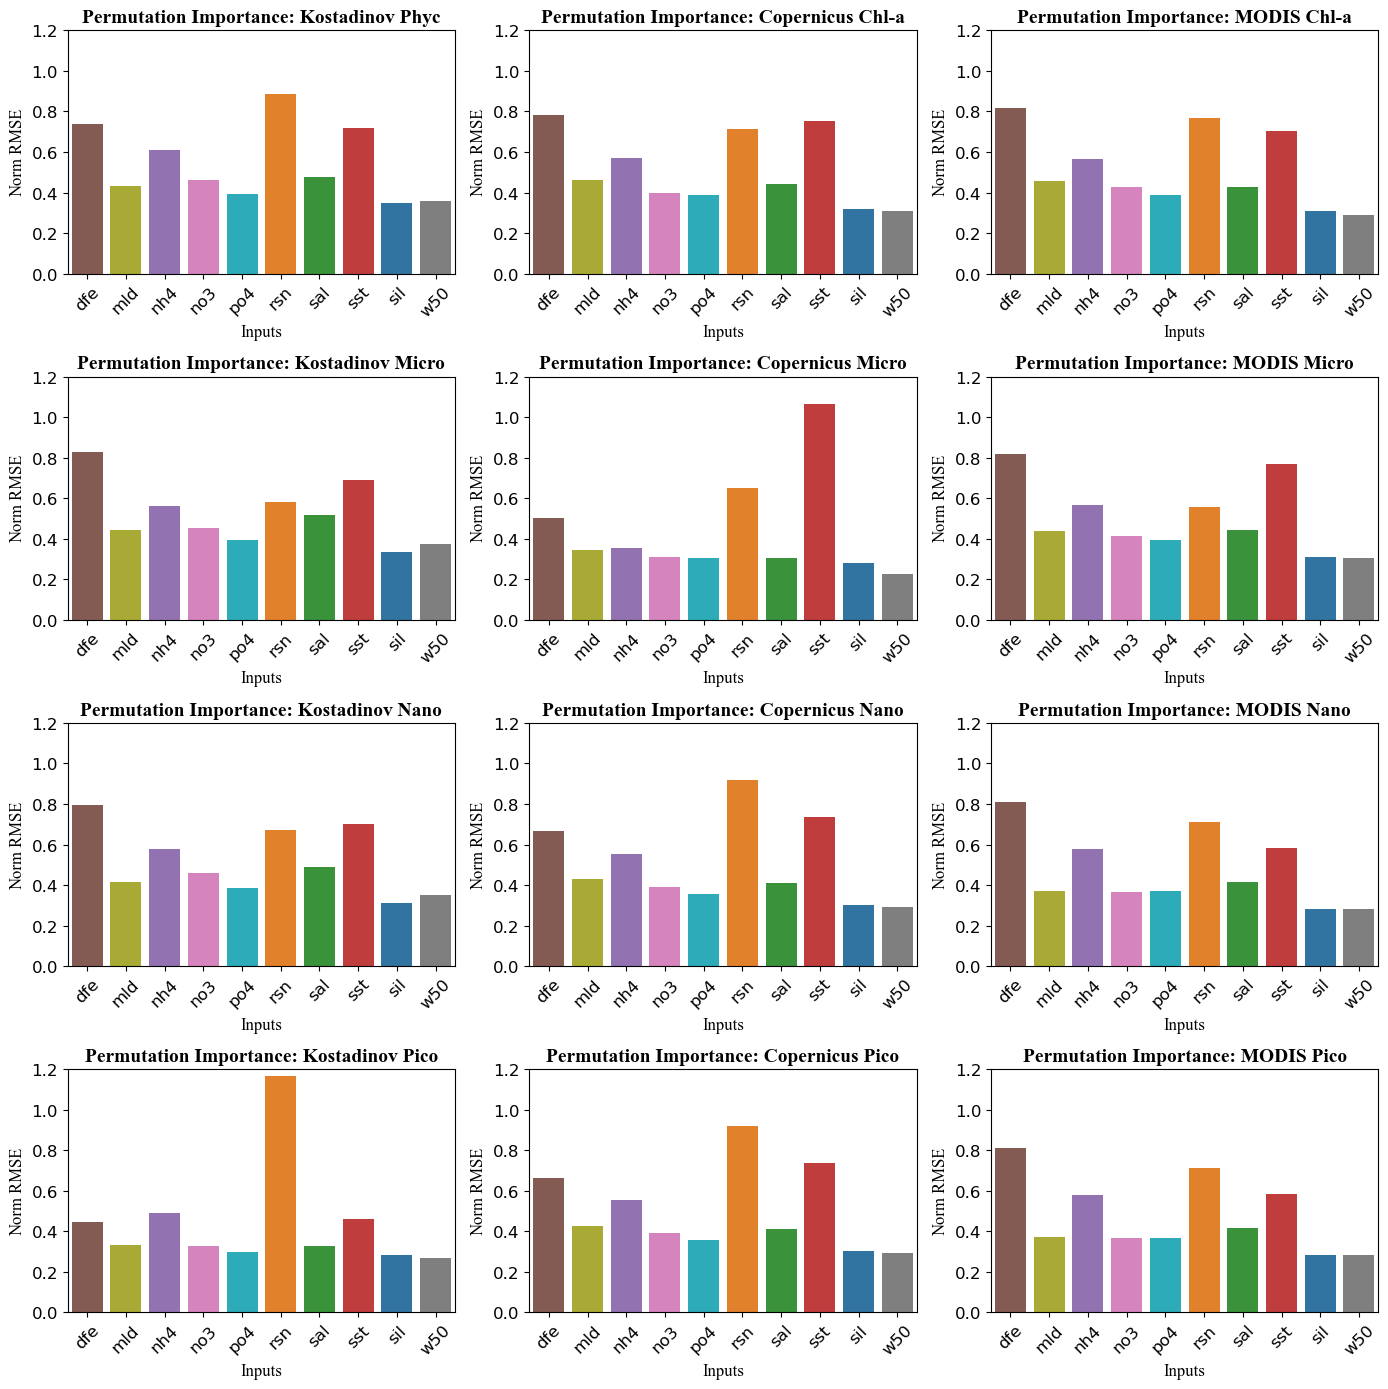

In [117]:
# Define datasets and titles
datasets = [
    {'df': pi_kostaphyc, 'y': 'norm_rmse', 'title': 'Kostadinov Phyc'},
    {'df': pi_coperchla, 'y': 'norm_rmse', 'title': 'Copernicus Chl-a'},
    {'df': pi_modischla, 'y': 'norm_rmse', 'title': 'MODIS Chl-a'},
    {'df': pi_kostamcro, 'y': 'norm_rmse', 'title': 'Kostadinov Micro'},
    {'df': pi_copermcro, 'y': 'norm_rmse', 'title': 'Copernicus Micro'},
    {'df': pi_modismcro, 'y': 'norm_rmse', 'title': 'MODIS Micro'},
    {'df': pi_kostanano, 'y': 'norm_rmse', 'title': 'Kostadinov Nano'},
    {'df': pi_copernano, 'y': 'norm_rmse', 'title': 'Copernicus Nano'},
    {'df': pi_modisnano, 'y': 'norm_rmse', 'title': 'MODIS Nano'},
    {'df': pi_kostapico, 'y': 'norm_rmse', 'title': 'Kostadinov Pico'},
    {'df': pi_copernano, 'y': 'norm_rmse', 'title': 'Copernicus Pico'},
    {'df': pi_modisnano, 'y': 'norm_rmse', 'title': 'MODIS Pico'}
]

# Font settings
font = {'family': 'Times New Roman', 'color': 'black', 'fontsize': 14, 'fontweight': 'bold'}
fonttxt = {'family': 'Times New Roman', 'color': 'black', 'fontsize': 12}

# Create subplots (4 rows × 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(14, 14), sharex=False, sharey=False, dpi=100)
axes = axes.flatten()  # Flatten to 1D list for easy iteration

# Plot each dataset
for ax, data in zip(axes, datasets):
    sns.barplot(x='Inputs', y=data['y'], data=data['df'], ax=ax, palette=my_colors, hue='Inputs', legend=False)
    
    ax.set_title(f"Permutation Importance: {data['title']}", fontdict=font)
    ax.set_ylabel("Norm RMSE", fontdict=fonttxt)
    ax.set_ylim([0.0, 1.2])
    ax.set_xlabel("Inputs", fontdict=fonttxt)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.tick_params(axis='x', labelrotation=45)

    
    # Remove legend if present
    if ax.get_legend():
        ax.get_legend().remove()

# Hide any unused axes (in case datasets < total subplots)
for ax in axes[len(datasets):]:
    ax.axis('off')

plt.tight_layout()
fig.savefig(chartpath + "pi_imp_multigroup_scratch.jpg",dpi=200,bbox_inches='tight')
plt.show()

### ALE from Scratch

In [80]:
def compute_ale(X, model, feature, n_quantiles=100):
    """
    Compute Accumulated Local Effects (ALE) for a single feature.
    
    Parameters:
    - X: pd.DataFrame, input data
    - model: trained model with .predict() method
    - feature: str, name of the feature to compute ALE for
    - bins: int, number of bins to divide the feature range
    
    Returns:
    - ale_df: pd.DataFrame with columns ['bin_center', 'ALE']
    """
    x_feature = X[feature].values
    
    # Use quantiles as cut points
    quantiles = np.quantile(x_feature, np.linspace(0, 1, n_quantiles + 1))
    quantiles = np.unique(quantiles)  # ensure uniqueness
    
    ale_values = []
    bin_centers = []
    
    for i in range(1, len(quantiles)):
        lower, upper = quantiles[i-1], quantiles[i]
        mask = (x_feature >= lower) & (x_feature < upper)
        X_bin = X[mask].copy()
        
        if len(X_bin) == 0:
            ale_values.append(0)
            bin_centers.append((lower + upper) / 2)
            continue
        
        # Predict with feature = upper
        X_bin[feature] = upper
        preds_upper = model.predict(X_bin)
        
        # Predict with feature = lower
        X_bin[feature] = lower
        preds_lower = model.predict(X_bin)
        
        # Average difference
        delta = np.mean(preds_upper - preds_lower)
        
        ale_values.append(delta)
        bin_centers.append((lower + upper) / 2)
    
    # Accumulate effects
    ale_cum = np.cumsum(ale_values) 
    
    # # Center ALE to have mean zero
    # ale_cum -= np.mean(ale_cum)

    # Center ALE around median instead of mean
    ale_cum -= np.median(ale_cum)
    
    ale_df = pd.DataFrame({
        "bin_center": bin_centers,
        "ALE": ale_cum
    })
    
    return ale_df

In [81]:
ale_kostaphyc_sst = compute_ale(Xk_train, kosta_phyc, feature='sst', n_quantiles=100)
ale_coperchla_sst = compute_ale(Xc_train, coper_chla, feature='sst', n_quantiles=100)
ale_modischla_sst = compute_ale(Xh_train, modis_chla, feature='sst', n_quantiles=100)

In [82]:
ale_kostaphyc_rsn = compute_ale(Xk_train, kosta_phyc, feature='rsn', n_quantiles=100)
ale_coperchla_rsn = compute_ale(Xc_train, coper_chla, feature='rsn', n_quantiles=100)
ale_modischla_rsn = compute_ale(Xh_train, modis_chla, feature='rsn', n_quantiles=100)

In [83]:
ale_kostaphyc_dfe = compute_ale(Xk_train, kosta_phyc, feature='dfe', n_quantiles=100)
ale_coperchla_dfe = compute_ale(Xc_train, coper_chla, feature='dfe', n_quantiles=100)
ale_modischla_dfe = compute_ale(Xh_train, modis_chla, feature='dfe', n_quantiles=100)

In [84]:
ale_kostaphyc_nh4 = compute_ale(Xk_train, kosta_phyc, feature='nh4', n_quantiles=100)
ale_coperchla_nh4 = compute_ale(Xc_train, coper_chla, feature='nh4', n_quantiles=100)
ale_modischla_nh4 = compute_ale(Xh_train, modis_chla, feature='nh4', n_quantiles=100)

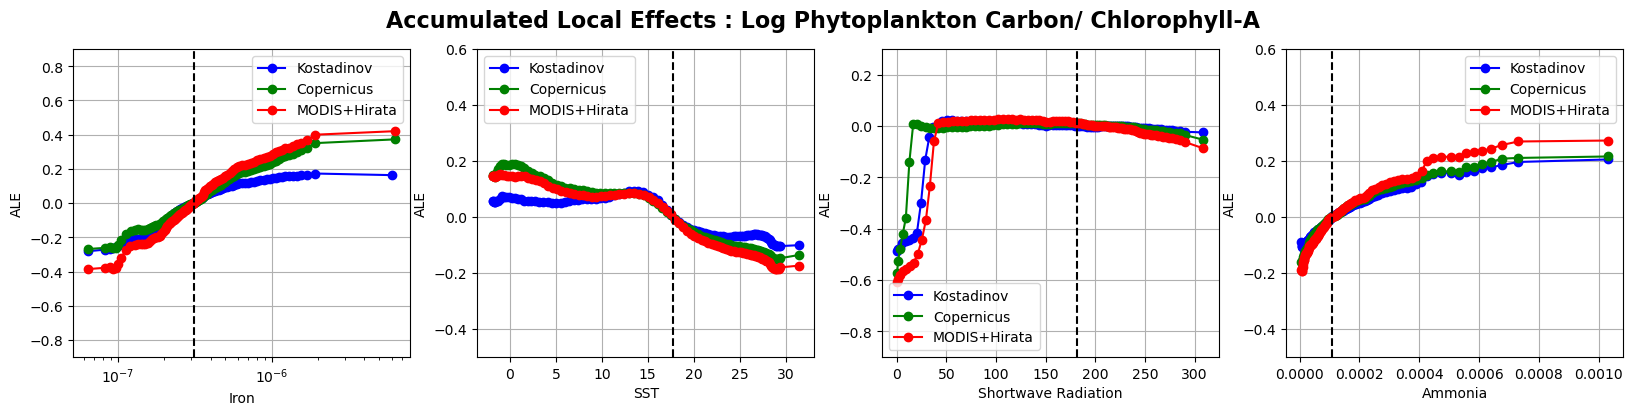

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,4, figsize=(20,4), dpi=100)
fig.suptitle("Accumulated Local Effects : Log Phytoplankton Carbon/ Chlorophyll-A", fontsize=16, fontweight='bold')

# Assuming ale_kostaphyc_sst and ale_result are already defined DataFrames
# Calculate the median of the x-axis feature
median_sst = ale_kostaphyc_sst['bin_center'].median()
median_rsn = ale_kostaphyc_rsn['bin_center'].median()
median_dfe = ale_kostaphyc_dfe['bin_center'].median()
median_nh4 = ale_kostaphyc_nh4['bin_center'].median()

# Plotting
ax[0].plot(ale_kostaphyc_dfe['bin_center'], ale_kostaphyc_dfe['ALE'], marker='o', color='blue', label='Kostadinov')
ax[0].plot(ale_coperchla_dfe['bin_center'], ale_coperchla_dfe['ALE'], marker='o', color='green', label='Copernicus')
ax[0].plot(ale_modischla_dfe['bin_center'], ale_modischla_dfe['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[1].plot(ale_kostaphyc_sst['bin_center'], ale_kostaphyc_sst['ALE'], marker='o', color='blue', label='Kostadinov')
ax[1].plot(ale_coperchla_sst['bin_center'], ale_coperchla_sst['ALE'], marker='o', color='green', label='Copernicus')
ax[1].plot(ale_modischla_sst['bin_center'], ale_modischla_sst['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[2].plot(ale_kostaphyc_rsn['bin_center'], ale_kostaphyc_rsn['ALE'], marker='o', color='blue', label='Kostadinov')
ax[2].plot(ale_coperchla_rsn['bin_center'], ale_coperchla_rsn['ALE'], marker='o', color='green', label='Copernicus')
ax[2].plot(ale_modischla_rsn['bin_center'], ale_modischla_rsn['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[3].plot(ale_kostaphyc_nh4['bin_center'], ale_kostaphyc_nh4['ALE'], marker='o', color='blue', label='Kostadinov')
ax[3].plot(ale_coperchla_nh4['bin_center'], ale_coperchla_nh4['ALE'], marker='o', color='green', label='Copernicus')
ax[3].plot(ale_modischla_nh4['bin_center'], ale_modischla_nh4['ALE'], marker='o', color='red', label='MODIS+Hirata')


# Set x-axis to log scale for Iron (ax[0])
ax[0].set_xscale('log', base=10)

# Add a vertical line at the median value
ax[0].axvline(x=median_dfe, color='k', linestyle='--')
ax[1].axvline(x=median_sst, color='k', linestyle='--')
ax[2].axvline(x=median_rsn, color='k', linestyle='--')
ax[3].axvline(x=median_nh4, color='k', linestyle='--')

ax[0].set_ylim([-0.9, 0.9])
ax[1].set_ylim([-0.5, 0.6])
ax[2].set_ylim([-0.9, 0.3])
ax[3].set_ylim([-0.5, 0.6])

ax[0].set_xlabel('Iron')
ax[1].set_xlabel('SST')
ax[2].set_xlabel('Shortwave Radiation')
ax[3].set_xlabel('Ammonia')

ax[0].set_ylabel('ALE')
ax[1].set_ylabel('ALE')
ax[2].set_ylabel('ALE')
ax[3].set_ylabel('ALE')

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

# fig.savefig(chartpath + "ale_chla_scaled_scratch.jpg", dpi=200, bbox_inches="tight")
plt.show()

In [86]:
ale_kostamcro_sst = compute_ale(Xk_train, kosta_mcro, feature='sst', n_quantiles=100)
ale_copermcro_sst = compute_ale(Xc_train, coper_mcro, feature='sst', n_quantiles=100)
ale_modismcro_sst = compute_ale(Xh_train, modis_mcro, feature='sst', n_quantiles=100)

In [87]:
ale_kostamcro_rsn = compute_ale(Xk_train, kosta_mcro, feature='rsn', n_quantiles=100)
ale_copermcro_rsn = compute_ale(Xc_train, coper_mcro, feature='rsn', n_quantiles=100)
ale_modismcro_rsn = compute_ale(Xh_train, modis_mcro, feature='rsn', n_quantiles=100)

In [88]:
ale_kostamcro_dfe = compute_ale(Xk_train, kosta_mcro, feature='dfe', n_quantiles=100)
ale_copermcro_dfe = compute_ale(Xc_train, coper_mcro, feature='dfe', n_quantiles=100)
ale_modismcro_dfe = compute_ale(Xh_train, modis_mcro, feature='dfe', n_quantiles=100)

In [89]:
ale_kostamcro_nh4 = compute_ale(Xk_train, kosta_mcro, feature='nh4', n_quantiles=100)
ale_copermcro_nh4 = compute_ale(Xc_train, coper_mcro, feature='nh4', n_quantiles=100)
ale_modismcro_nh4 = compute_ale(Xh_train, modis_mcro, feature='nh4', n_quantiles=100)

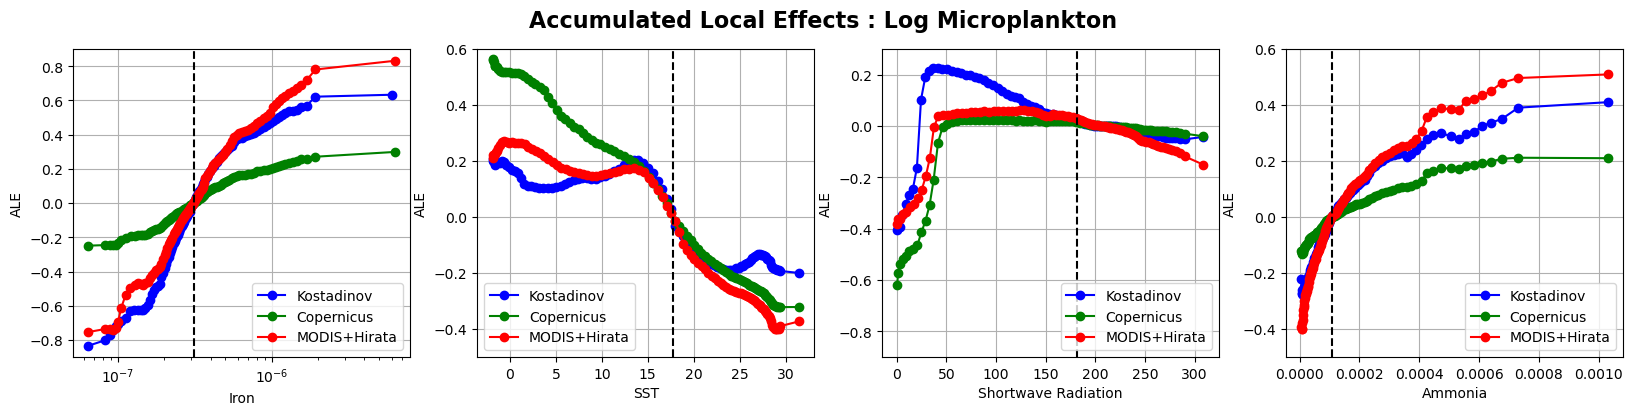

In [90]:
fig, ax = plt.subplots(1,4, figsize=(20,4), dpi=100)
fig.suptitle("Accumulated Local Effects : Log Microplankton", fontsize=16, fontweight='bold')

# Assuming ale_kostaphyc_sst and ale_result are already defined DataFrames
# Calculate the median of the x-axis feature
median_sst = ale_kostamcro_sst['bin_center'].median()
median_rsn = ale_kostamcro_rsn['bin_center'].median()
median_dfe = ale_kostamcro_dfe['bin_center'].median()

# Plotting
ax[0].plot(ale_kostamcro_dfe['bin_center'], ale_kostamcro_dfe['ALE'], marker='o', color='blue', label='Kostadinov')
ax[0].plot(ale_copermcro_dfe['bin_center'], ale_copermcro_dfe['ALE'], marker='o', color='green', label='Copernicus')
ax[0].plot(ale_modismcro_dfe['bin_center'], ale_modismcro_dfe['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[1].plot(ale_kostamcro_sst['bin_center'], ale_kostamcro_sst['ALE'], marker='o', color='blue', label='Kostadinov')
ax[1].plot(ale_copermcro_sst['bin_center'], ale_copermcro_sst['ALE'], marker='o', color='green', label='Copernicus')
ax[1].plot(ale_modismcro_sst['bin_center'], ale_modismcro_sst['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[2].plot(ale_kostamcro_rsn['bin_center'], ale_kostamcro_rsn['ALE'], marker='o', color='blue', label='Kostadinov')
ax[2].plot(ale_copermcro_rsn['bin_center'], ale_copermcro_rsn['ALE'], marker='o', color='green', label='Copernicus')
ax[2].plot(ale_modismcro_rsn['bin_center'], ale_modismcro_rsn['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[3].plot(ale_kostamcro_nh4['bin_center'], ale_kostamcro_nh4['ALE'], marker='o', color='blue', label='Kostadinov')
ax[3].plot(ale_copermcro_nh4['bin_center'], ale_copermcro_nh4['ALE'], marker='o', color='green', label='Copernicus')
ax[3].plot(ale_modismcro_nh4['bin_center'], ale_modismcro_nh4['ALE'], marker='o', color='red', label='MODIS+Hirata')

# Set x-axis to log scale for Iron (ax[0])
ax[0].set_xscale('log', base=10)

# Add a vertical line at the median value
ax[0].axvline(x=median_dfe, color='k', linestyle='--')
ax[1].axvline(x=median_sst, color='k', linestyle='--')
ax[2].axvline(x=median_rsn, color='k', linestyle='--')
ax[3].axvline(x=median_nh4, color='k', linestyle='--')

ax[0].set_xlabel('Iron')
ax[1].set_xlabel('SST')
ax[2].set_xlabel('Shortwave Radiation')
ax[3].set_xlabel('Ammonia')

ax[0].set_ylabel('ALE')
ax[1].set_ylabel('ALE')
ax[2].set_ylabel('ALE')
ax[3].set_ylabel('ALE')

ax[0].set_ylim([-0.9, 0.9])
ax[1].set_ylim([-0.5, 0.6])
ax[2].set_ylim([-0.9, 0.3])
ax[3].set_ylim([-0.5, 0.6])

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

# fig.savefig(chartpath + "ale_mcro_scaled_scratch.jpg", dpi=200, bbox_inches="tight")
plt.show()

In [91]:
ale_kostanano_sst = compute_ale(Xk_train, kosta_nano, feature='sst', n_quantiles=100)
ale_copernano_sst = compute_ale(Xc_train, coper_nano, feature='sst', n_quantiles=100)
ale_modisnano_sst = compute_ale(Xh_train, modis_nano, feature='sst', n_quantiles=100)

In [92]:
ale_kostanano_rsn = compute_ale(Xk_train, kosta_nano, feature='rsn', n_quantiles=100)
ale_copernano_rsn = compute_ale(Xc_train, coper_nano, feature='rsn', n_quantiles=100)
ale_modisnano_rsn = compute_ale(Xh_train, modis_nano, feature='rsn', n_quantiles=100)

In [93]:
ale_kostanano_dfe = compute_ale(Xk_train, kosta_nano, feature='dfe', n_quantiles=100)
ale_copernano_dfe = compute_ale(Xc_train, coper_nano, feature='dfe', n_quantiles=100)
ale_modisnano_dfe = compute_ale(Xh_train, modis_nano, feature='dfe', n_quantiles=100)

In [94]:
ale_kostanano_nh4 = compute_ale(Xk_train, kosta_nano, feature='nh4', n_quantiles=100)
ale_copernano_nh4 = compute_ale(Xc_train, coper_nano, feature='nh4', n_quantiles=100)
ale_modisnano_nh4 = compute_ale(Xh_train, modis_nano, feature='nh4', n_quantiles=100)

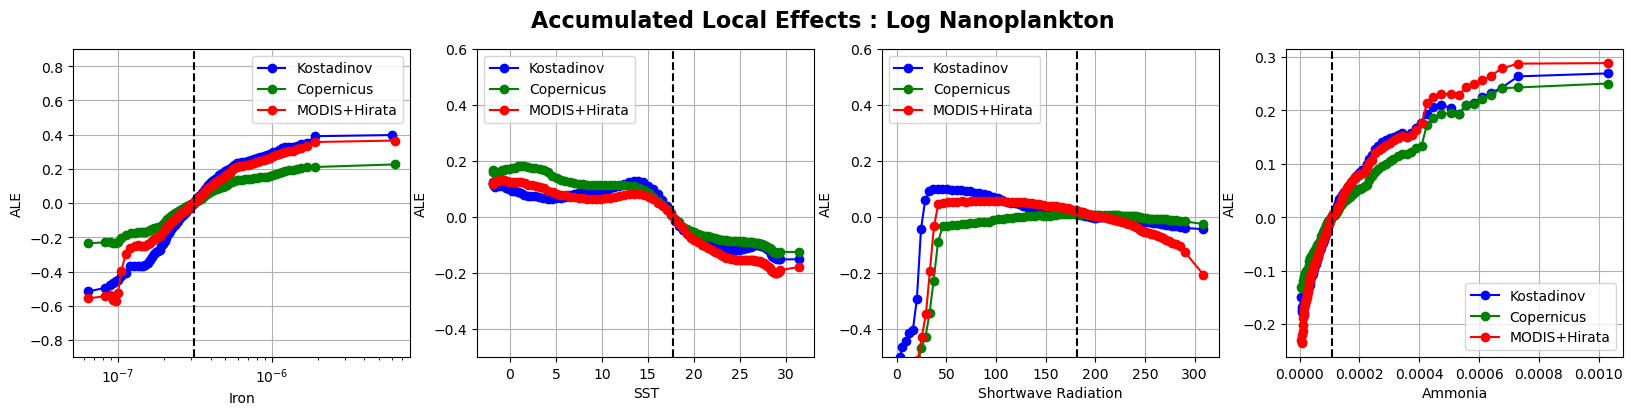

In [95]:
fig, ax = plt.subplots(1,4, figsize=(20,4), dpi=100)
fig.suptitle("Accumulated Local Effects : Log Nanoplankton", fontsize=16, fontweight='bold')

# Assuming ale_kostaphyc_sst and ale_result are already defined DataFrames
# Calculate the median of the x-axis feature
median_sst = ale_kostamcro_sst['bin_center'].median()
median_rsn = ale_kostamcro_rsn['bin_center'].median()
median_dfe = ale_kostamcro_dfe['bin_center'].median()
median_nh4 = ale_kostamcro_nh4['bin_center'].median()

# Plotting
ax[0].plot(ale_kostanano_dfe['bin_center'], ale_kostanano_dfe['ALE'], marker='o', color='blue', label='Kostadinov')
ax[0].plot(ale_copernano_dfe['bin_center'], ale_copernano_dfe['ALE'], marker='o', color='green', label='Copernicus')
ax[0].plot(ale_modisnano_dfe['bin_center'], ale_modisnano_dfe['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[1].plot(ale_kostanano_sst['bin_center'], ale_kostanano_sst['ALE'], marker='o', color='blue', label='Kostadinov')
ax[1].plot(ale_copernano_sst['bin_center'], ale_copernano_sst['ALE'], marker='o', color='green', label='Copernicus')
ax[1].plot(ale_modisnano_sst['bin_center'], ale_modisnano_sst['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[2].plot(ale_kostanano_rsn['bin_center'], ale_kostanano_rsn['ALE'], marker='o', color='blue', label='Kostadinov')
ax[2].plot(ale_copernano_rsn['bin_center'], ale_copernano_rsn['ALE'], marker='o', color='green', label='Copernicus')
ax[2].plot(ale_modisnano_rsn['bin_center'], ale_modisnano_rsn['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[3].plot(ale_kostanano_nh4['bin_center'], ale_kostanano_nh4['ALE'], marker='o', color='blue', label='Kostadinov')
ax[3].plot(ale_copernano_nh4['bin_center'], ale_copernano_nh4['ALE'], marker='o', color='green', label='Copernicus')
ax[3].plot(ale_modisnano_nh4['bin_center'], ale_modisnano_nh4['ALE'], marker='o', color='red', label='MODIS+Hirata')

# Set x-axis to log scale for Iron (ax[0])
ax[0].set_xscale('log', base=10)

# Add a vertical line at the median value
ax[0].axvline(x=median_dfe, color='k', linestyle='--')
ax[1].axvline(x=median_sst, color='k', linestyle='--')
ax[2].axvline(x=median_rsn, color='k', linestyle='--')
ax[3].axvline(x=median_nh4, color='k', linestyle='--')

ax[0].set_xlabel('Iron')
ax[1].set_xlabel('SST')
ax[2].set_xlabel('Shortwave Radiation')
ax[3].set_xlabel('Ammonia')

ax[0].set_ylabel('ALE')
ax[1].set_ylabel('ALE')
ax[2].set_ylabel('ALE')
ax[3].set_ylabel('ALE')

ax[0].set_ylim([-0.9, 0.9])
ax[1].set_ylim([-0.5, 0.6])
ax[2].set_ylim([-0.5, 0.6])
# ax[3].set_ylim([-0.9, 0.3])

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

# fig.savefig(chartpath + "ale_nano_scaled_scratch.jpg", dpi=200, bbox_inches="tight")
plt.show()

In [96]:
ale_kostapico_sst = compute_ale(Xk_train, kosta_pico, feature='sst', n_quantiles=100)
ale_coperpico_sst = compute_ale(Xc_train, coper_pico, feature='sst', n_quantiles=100)
ale_modispico_sst = compute_ale(Xh_train, modis_pico, feature='sst', n_quantiles=100)

In [97]:
ale_kostapico_rsn = compute_ale(Xk_train, kosta_pico, feature='rsn', n_quantiles=100)
ale_coperpico_rsn = compute_ale(Xc_train, coper_pico, feature='rsn', n_quantiles=100)
ale_modispico_rsn = compute_ale(Xh_train, modis_pico, feature='rsn', n_quantiles=100)

In [98]:
ale_kostapico_dfe = compute_ale(Xk_train, kosta_pico, feature='dfe', n_quantiles=100)
ale_coperpico_dfe = compute_ale(Xc_train, coper_pico, feature='dfe', n_quantiles=100)
ale_modispico_dfe = compute_ale(Xh_train, modis_pico, feature='dfe', n_quantiles=100)

In [99]:
ale_kostapico_nh4 = compute_ale(Xk_train, kosta_pico, feature='nh4', n_quantiles=100)
ale_coperpico_nh4 = compute_ale(Xc_train, coper_pico, feature='nh4', n_quantiles=100)
ale_modispico_nh4 = compute_ale(Xh_train, modis_pico, feature='nh4', n_quantiles=100)

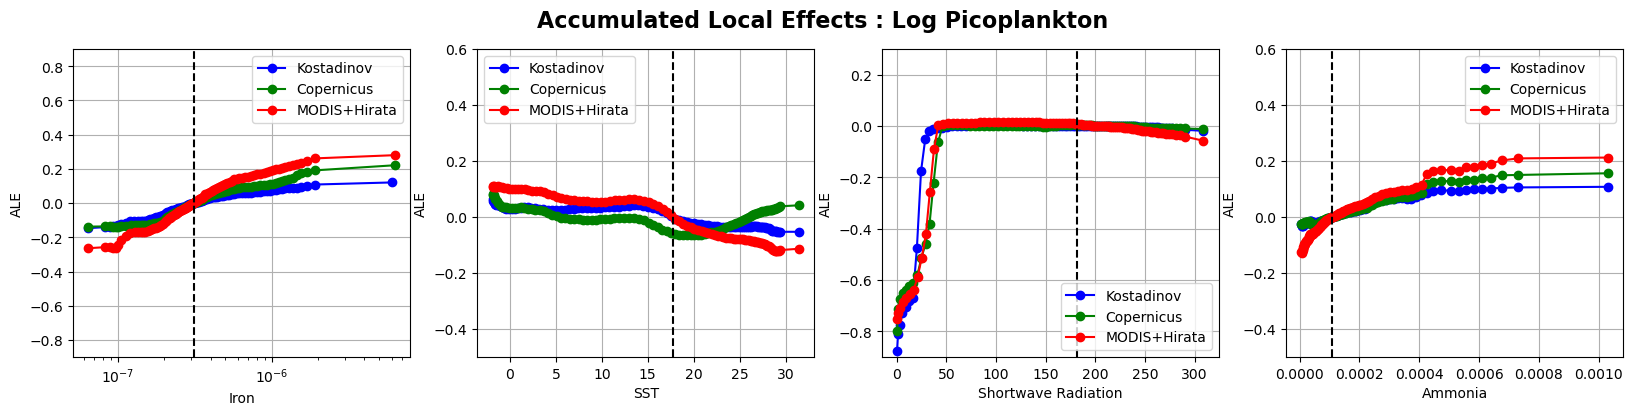

In [100]:
fig, ax = plt.subplots(1,4, figsize=(20,4), dpi=100)
fig.suptitle("Accumulated Local Effects : Log Picoplankton", fontsize=16, fontweight='bold')

# Assuming ale_kostaphyc_sst and ale_result are already defined DataFrames
# Calculate the median of the x-axis feature
median_sst = ale_kostamcro_sst['bin_center'].median()
median_rsn = ale_kostamcro_rsn['bin_center'].median()
median_dfe = ale_kostamcro_dfe['bin_center'].median()
median_nh4 = ale_kostamcro_nh4['bin_center'].median()

# Plotting
ax[0].plot(ale_kostapico_dfe['bin_center'], ale_kostapico_dfe['ALE'], marker='o', color='blue', label='Kostadinov')
ax[0].plot(ale_coperpico_dfe['bin_center'], ale_coperpico_dfe['ALE'], marker='o', color='green', label='Copernicus')
ax[0].plot(ale_modispico_dfe['bin_center'], ale_modispico_dfe['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[1].plot(ale_kostapico_sst['bin_center'], ale_kostapico_sst['ALE'], marker='o', color='blue', label='Kostadinov')
ax[1].plot(ale_coperpico_sst['bin_center'], ale_coperpico_sst['ALE'], marker='o', color='green', label='Copernicus')
ax[1].plot(ale_modispico_sst['bin_center'], ale_modispico_sst['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[2].plot(ale_kostapico_rsn['bin_center'], ale_kostapico_rsn['ALE'], marker='o', color='blue', label='Kostadinov')
ax[2].plot(ale_coperpico_rsn['bin_center'], ale_coperpico_rsn['ALE'], marker='o', color='green', label='Copernicus')
ax[2].plot(ale_modispico_rsn['bin_center'], ale_modispico_rsn['ALE'], marker='o', color='red', label='MODIS+Hirata')

ax[3].plot(ale_kostapico_nh4['bin_center'], ale_kostapico_nh4['ALE'], marker='o', color='blue', label='Kostadinov')
ax[3].plot(ale_coperpico_nh4['bin_center'], ale_coperpico_nh4['ALE'], marker='o', color='green', label='Copernicus')
ax[3].plot(ale_modispico_nh4['bin_center'], ale_modispico_nh4['ALE'], marker='o', color='red', label='MODIS+Hirata')

# Set x-axis to log scale for Iron (ax[0])
ax[0].set_xscale('log', base=10)

# Add a vertical line at the median value
ax[0].axvline(x=median_dfe, color='k', linestyle='--')
ax[1].axvline(x=median_sst, color='k', linestyle='--')
ax[2].axvline(x=median_rsn, color='k', linestyle='--')
ax[3].axvline(x=median_nh4, color='k', linestyle='--')

ax[0].set_xlabel('Iron')
ax[1].set_xlabel('SST')
ax[2].set_xlabel('Shortwave Radiation')
ax[3].set_xlabel('Ammonia')

ax[0].set_ylabel('ALE')
ax[1].set_ylabel('ALE')
ax[2].set_ylabel('ALE')
ax[3].set_ylabel('ALE')

ax[0].set_ylim([-0.9, 0.9])
ax[1].set_ylim([-0.5, 0.6])
ax[2].set_ylim([-0.9, 0.3])
ax[3].set_ylim([-0.5, 0.6])

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

# fig.savefig(chartpath + "ale_pico_scaled_scratch.jpg", dpi=200, bbox_inches="tight")
plt.show()

In [97]:
# import matplotlib.pyplot as plt

# # Define all ALE datasets and labels
# ale_sets = [
#     ('ale_kostaphyc', 'Kostadinov Phyc'),
#     ('ale_coperchla', 'Copernicus Chl-a'),
#     ('ale_modischla', 'MODIS Chl-a'),
#     ('ale_kostamcro', 'Kostadinov Micro'),
#     ('ale_copermcro', 'Copernicus Micro'),
#     ('ale_modismcro', 'MODIS Micro'),
#     ('ale_kostanano', 'Kostadinov Nano'),
#     ('ale_copernano', 'Copernicus Nano'),
#     ('ale_modisnano', 'MODIS Nano')
# ]

# features = ['dfe', 'sst', 'rsn']
# feature_labels = {'dfe': 'Iron', 'sst': 'SST', 'rsn': 'Shortwave Radiation'}

# colors = ['blue', 'green', 'red']  # Optional: assign per model group

# # Create subplots: 9 rows × 3 columns
# fig, axes = plt.subplots(len(ale_sets), len(features), figsize=(18, 36), dpi=100)
# fig.suptitle("Accumulated Local Effects", fontsize=18, fontweight='bold')

# # Loop through each model-feature combination
# for row_idx, (prefix, label) in enumerate(ale_sets):
#     for col_idx, feat in enumerate(features):
#         ax = axes[row_idx, col_idx]
#         try:
#             # Dynamically access the ALE DataFrame
#             ale_df = globals()[f"{prefix}_{feat}"]
#             ax.plot(ale_df['bin_center'], ale_df['ALE'], marker='o', color=colors[col_idx], label=label)

#             # Set log scale for Iron
#             if feat == 'dfe':
#                 ax.set_xscale('log', base=10)

#             # Add vertical line at median
#             median_val = ale_df['bin_center'].median()
#             ax.axvline(x=median_val, color='k', linestyle='--')

#             # Axis labels
#             if row_idx == len(ale_sets) - 1:
#                 ax.set_xlabel(feature_labels[feat], fontsize=12)
#             if col_idx == 0:
#                 ax.set_ylabel(label, fontsize=12)

#             ax.grid(True)
#             ax.tick_params(axis='x', labelrotation=45)
#         except KeyError:
#             print(f"Missing: {prefix}_{feat}")
#             ax.set_visible(False)
#             continue


# # Adjust layout
# plt.tight_layout(rect=[0, 0, 1, 0.97])
# # fig.savefig(chartpath + "ale_all_scaled.jpg", dpi=200, bbox_inches="tight")
# plt.show()

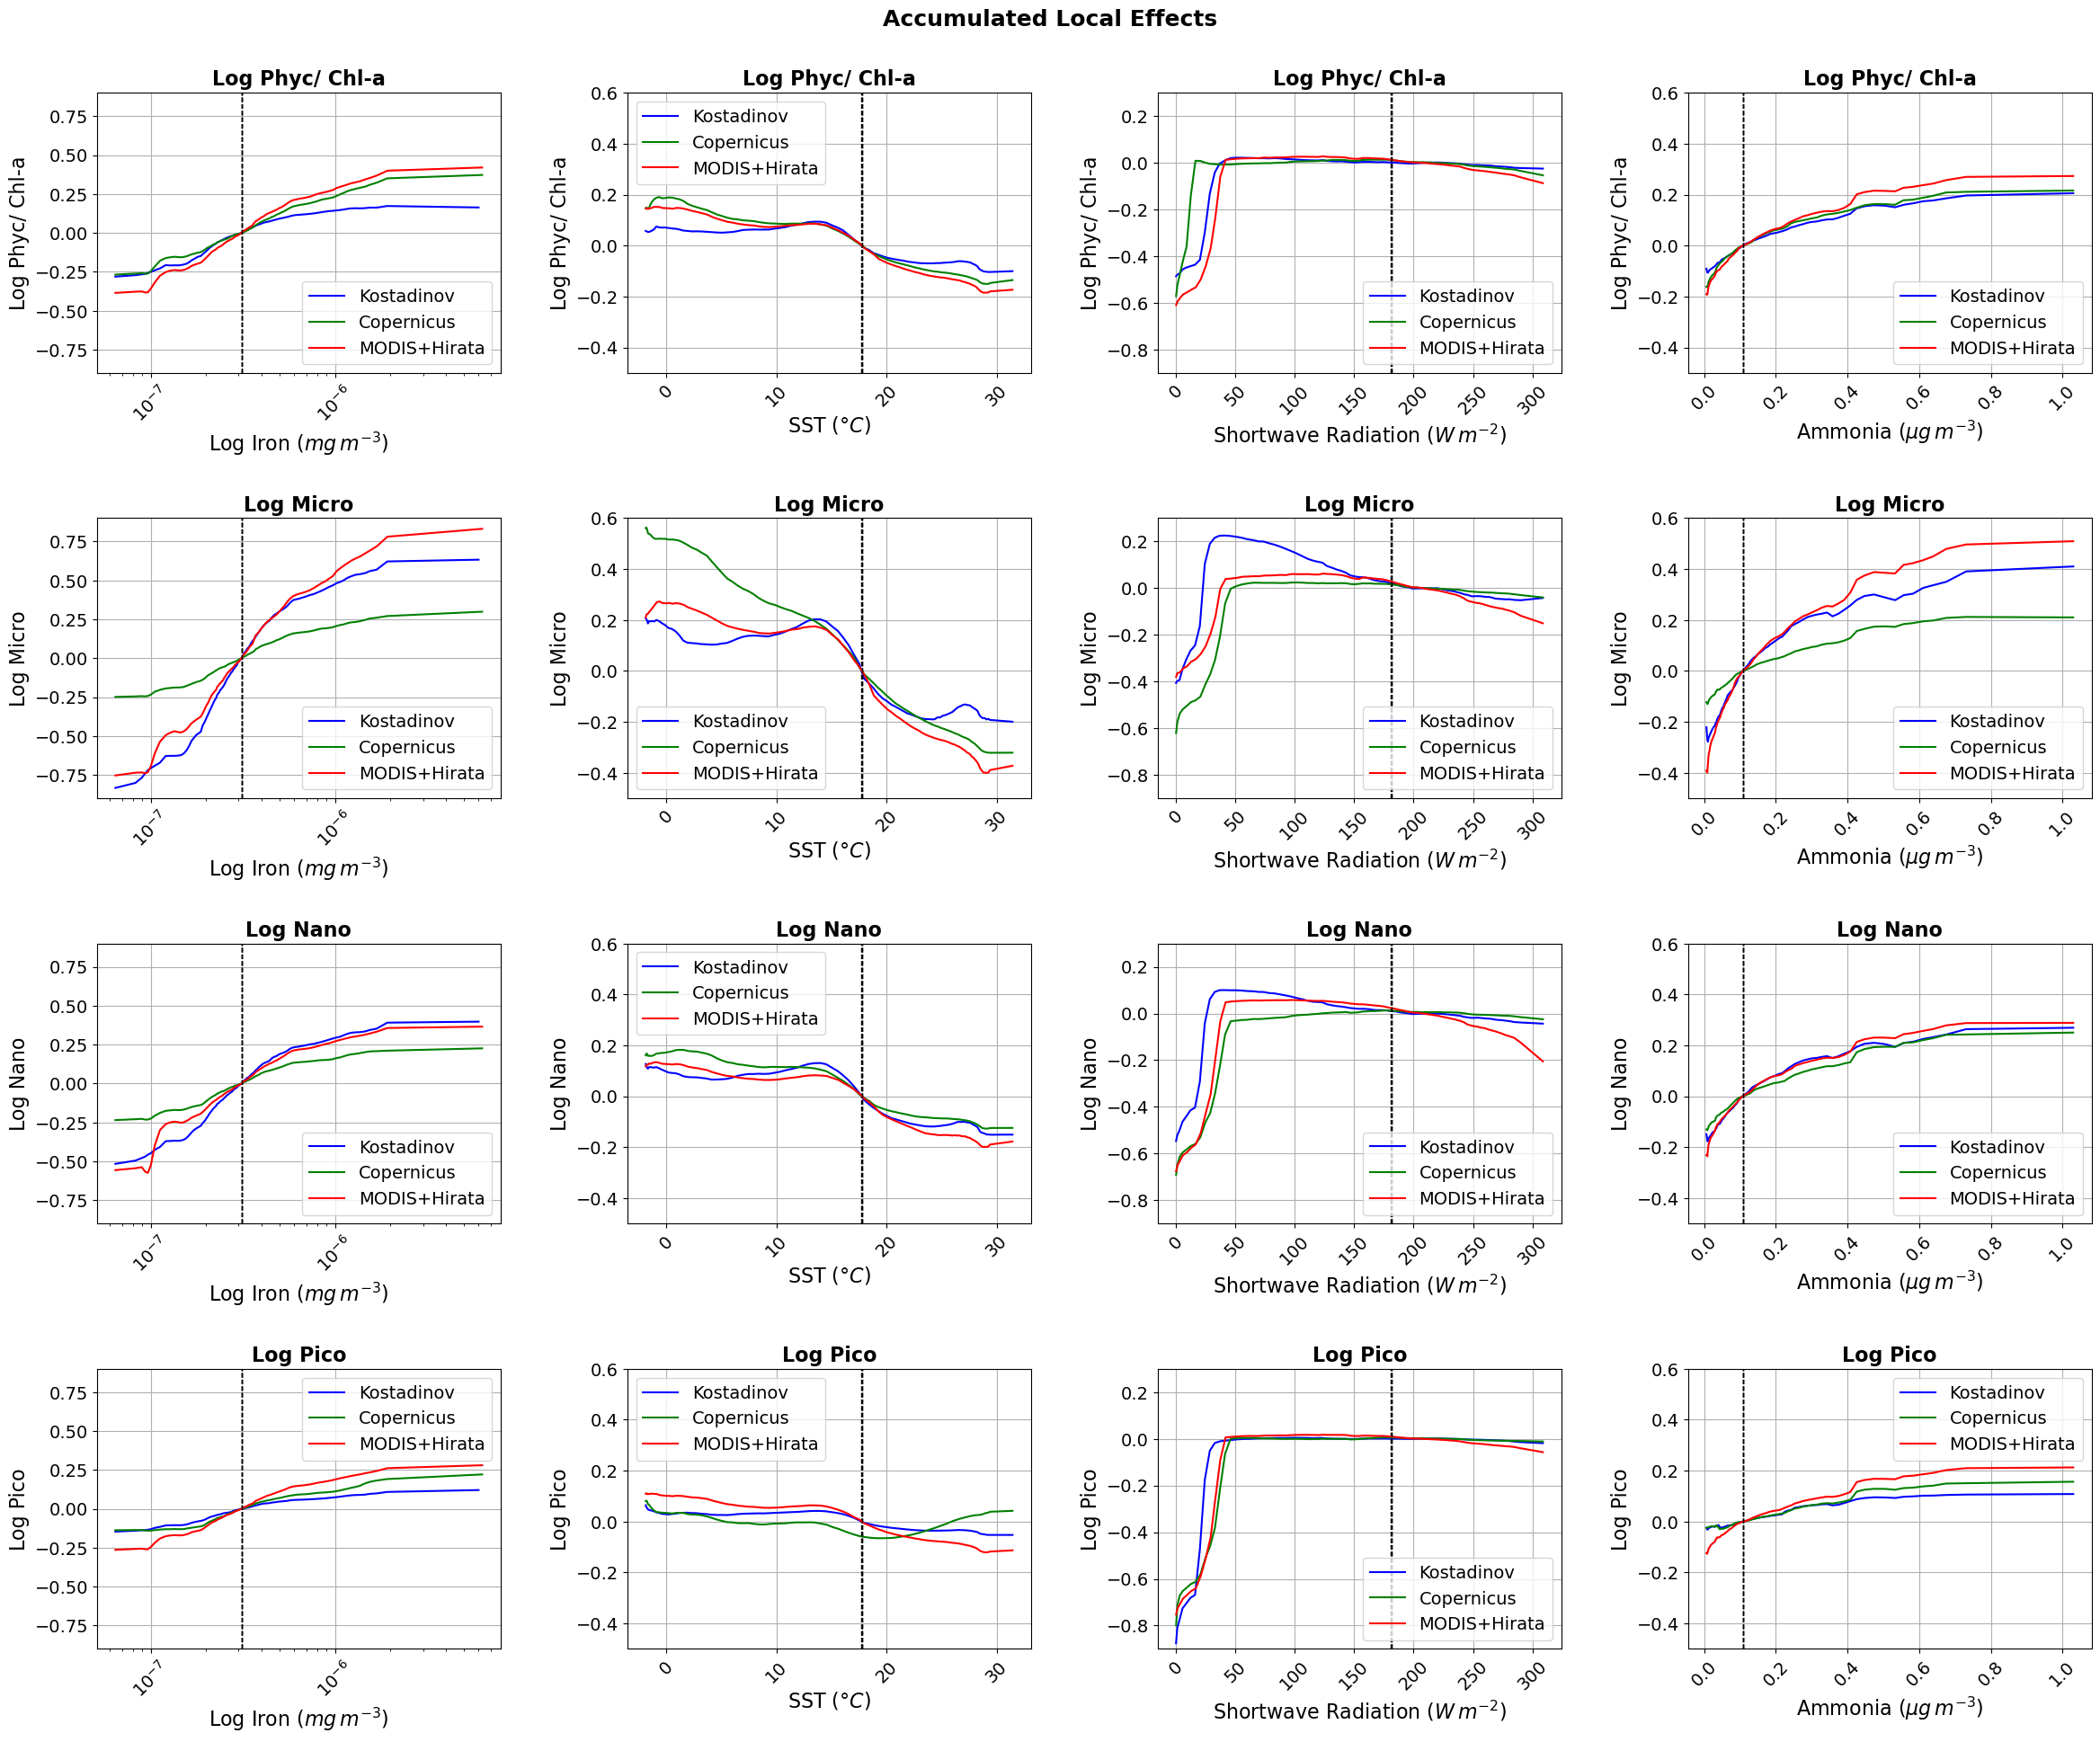

In [153]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define groups and their ALE datasets
groups = {
    'Log Phyc/ Chl-a': {
        'dfe': [ale_kostaphyc_dfe, ale_coperchla_dfe, ale_modischla_dfe],
        'sst': [ale_kostaphyc_sst, ale_coperchla_sst, ale_modischla_sst],
        'rsn': [ale_kostaphyc_rsn, ale_coperchla_rsn, ale_modischla_rsn],
        'nh4': [ale_kostaphyc_nh4, ale_coperchla_nh4, ale_modischla_nh4]
    },
    'Log Micro': {
        'dfe': [ale_kostamcro_dfe, ale_copermcro_dfe, ale_modismcro_dfe],
        'sst': [ale_kostamcro_sst, ale_copermcro_sst, ale_modismcro_sst],
        'rsn': [ale_kostamcro_rsn, ale_copermcro_rsn, ale_modismcro_rsn],
        'nh4': [ale_kostamcro_nh4, ale_copermcro_nh4, ale_modismcro_nh4]
    },
    'Log Nano': {
        'dfe': [ale_kostanano_dfe, ale_copernano_dfe, ale_modisnano_dfe],
        'sst': [ale_kostanano_sst, ale_copernano_sst, ale_modisnano_sst],
        'rsn': [ale_kostanano_rsn, ale_copernano_rsn, ale_modisnano_rsn],
        'nh4': [ale_kostanano_nh4, ale_copernano_nh4, ale_modisnano_nh4]
    },
    'Log Pico': {
        'dfe': [ale_kostapico_dfe, ale_coperpico_dfe, ale_modispico_dfe],
        'sst': [ale_kostapico_sst, ale_coperpico_sst, ale_modispico_sst],
        'rsn': [ale_kostapico_rsn, ale_coperpico_rsn, ale_modispico_rsn],
        'nh4': [ale_kostapico_nh4, ale_coperpico_nh4, ale_modispico_nh4]
    }
}

colors = ['blue', 'green', 'red']
labels = ['Kostadinov', 'Copernicus', 'MODIS+Hirata']
feature_titles = {
    'dfe': r'Log Iron (${mg}\, m^{-3}$)', 
    'sst': r'SST ($\degree C$)',
    'rsn': r'Shortwave Radiation (${W}\, m^{-2}$)', 
    'nh4': r'Ammonia (${\mu g}\, m^{-3}$)'
}
# Define custom y-axis limits per feature
ylim_settings = {
    'dfe': (-0.9, 0.9),
    'sst': (-0.5, 0.6),
    'rsn': (-0.9, 0.3),
    'nh4': (-0.5, 0.6)
}

# Define a formatter function
def format_multiples_of_e3(x, pos):
    # Convert x to multiples of 1e-4
    return f'{x * 1e3:.1f}'  # Formats the label with one decimal place

# Dynamically determine grid size
n_rows = len(groups)
n_cols = len(feature_titles)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), dpi=100)
axes = axes if n_rows > 1 else [axes]  # Handle single-row case
fig.suptitle("Accumulated Local Effects", fontsize=18, fontweight='bold')

# Plotting loop
for row_idx, (group_name, features) in enumerate(groups.items()):
    for col_idx, (feature, dfs) in enumerate(features.items()):
        ax = axes[row_idx][col_idx] if n_rows > 1 else axes[col_idx]
        for df, color, label in zip(dfs, colors, labels):
            ax.plot(df['bin_center'], df['ALE'], color=color, label=label)
            ax.axvline(x=df['bin_center'].median(), color='k', linestyle='--', linewidth=1)

        # Set subplot title
        ax.set_title(f"{group_name}", fontsize=16, fontweight='bold')

        # Set axis labels
        ax.set_xlabel(feature_titles[feature], fontsize=16)
        ax.set_ylabel(group_name, fontsize=16)

        # Apply feature-specific y-axis limits
        ax.set_ylim(ylim_settings[feature])

        ax.tick_params(axis='both', labelsize=14)

        # Log scale for 'dfe'
        if feature == 'dfe':
            ax.set_xscale('log', base=10)

        if feature == 'nh4':
            # Set the formatter for the x-axis directly on ax
            ax.xaxis.set_major_formatter(FuncFormatter(format_multiples_of_e3))

        ax.grid(True)
        ax.tick_params(axis='x', labelrotation=45)
        ax.legend(loc='best', fontsize=14)

# Adjust the layout
plt.tight_layout(pad=3.0, w_pad=4.0, h_pad=None)

fig.savefig(chartpath + "ale_multigroup_scaled.jpg", dpi=200, bbox_inches="tight")
plt.show()

### Variable Importance

In [118]:
def compute_ale_multi(X, model, features, bins=20):
    """
    Compute Accumulated Local Effects (ALE) for multiple features.
    
    Parameters:
    - X: pd.DataFrame, input data
    - model: trained model with .predict() method
    - features: list of str, names of the features to compute ALE for
    - bins: int, number of bins to divide each feature range
    
    Returns:
    - ale_df: pd.DataFrame with columns ['feature', 'bin_center', 'ALE']
    """
    all_ales = []

    for feature in features:
        x_feature = X[feature].values
        quantiles = np.quantile(x_feature, np.linspace(0, 1, bins + 1))

        ale_values = []
        bin_centers = []

        for i in range(1, len(quantiles)):
            lower, upper = quantiles[i-1], quantiles[i]
            mask = (x_feature >= lower) & (x_feature < upper)
            X_bin = X[mask].copy()

            if len(X_bin) == 0:
                ale_values.append(0)
                bin_centers.append((lower + upper) / 2)
                continue

            # Predict with feature = upper
            X_bin[feature] = upper
            preds_upper = model.predict(X_bin)

            # Predict with feature = lower
            X_bin[feature] = lower
            preds_lower = model.predict(X_bin)

            # Average difference
            delta = np.mean(preds_upper - preds_lower)

            ale_values.append(delta)
            bin_centers.append((lower + upper) / 2)

        # Accumulate effects
        ale_cum = np.cumsum(ale_values)

        # Center ALE to have mean zero
        ale_cum -= np.mean(ale_cum)

        # Collect results
        df = pd.DataFrame({
            "feature": feature,
            "bin_center": bin_centers,
            "ALE": ale_cum
        })
        all_ales.append(df)

    # Combine into single DataFrame
    ale_df = pd.concat(all_ales, ignore_index=True)
    return ale_df

In [119]:
features = Xk.columns.to_list()

In [120]:
exp_kostaphyc = compute_ale_multi(Xk, kosta_phyc, features, bins=20)
exp_coperchla = compute_ale_multi(Xc, coper_chla, features, bins=20)
exp_modischla = compute_ale_multi(Xh, modis_chla, features, bins=20)

In [121]:
exp_kostaphyc

,feature,bin_center,ALE
0,dfe,7.438728e-08,-0.270583
1,dfe,1.150132e-07,-0.211678
2,dfe,1.452120e-07,-0.198045
3,dfe,1.716450e-07,-0.152132
4,dfe,1.960377e-07,-0.098119
...,...,...,...
195,w50,1.252520e-06,0.004790
196,w50,1.597807e-06,0.002637
197,w50,2.113793e-06,0.002246
198,w50,3.234453e-06,0.005999


In [122]:
exp_kostaphyc[exp_kostaphyc['feature']=='dfe']['ALE'].std()

np.float64(0.13223904742705467)

In [123]:
features

['dfe', 'mld', 'nh4', 'no3', 'po4', 'rsn', 'sal', 'sst', 'sil', 'w50']

In [124]:
kostaphyc = {}
coperchla = {}
modischla = {}
for f in features:
    kostaphyc[f] =exp_kostaphyc[exp_kostaphyc['feature']== f]['ALE'].std()
    coperchla[f] =exp_coperchla[exp_coperchla['feature']== f]['ALE'].std()
    modischla[f] =exp_modischla[exp_modischla['feature']== f]['ALE'].std()

In [125]:
data_phyc = {
    'kostaphyc': kostaphyc,
    'coperchla': coperchla,
    'modischla': modischla
}

In [126]:
data_phyc

{'kostaphyc': {'dfe': np.float64(0.13223904742705467),
  'mld': np.float64(0.02645600275292867),
  'nh4': np.float64(0.08470344886226282),
  'no3': np.float64(0.024642029831763012),
  'po4': np.float64(0.015862456404682583),
  'rsn': np.float64(0.14815663220048877),
  'sal': np.float64(0.03484761670088628),
  'sst': np.float64(0.07118238929657618),
  'sil': np.float64(0.015679564149737493),
  'w50': np.float64(0.011342083851383238)},
 'coperchla': {'dfe': np.float64(0.17181426613400608),
  'mld': np.float64(0.03623297904447079),
  'nh4': np.float64(0.09525938839704552),
  'no3': np.float64(0.022488752772995),
  'po4': np.float64(0.01960396944495069),
  'rsn': np.float64(0.13109828647508168),
  'sal': np.float64(0.04087554303950357),
  'sst': np.float64(0.12549388075464585),
  'sil': np.float64(0.031753640959669545),
  'w50': np.float64(0.013866571196233317)},
 'modischla': {'dfe': np.float64(0.21893697305383264),
  'mld': np.float64(0.04262531695533319),
  'nh4': np.float64(0.117508972

In [127]:
phyc = pd.DataFrame(data_phyc)

In [128]:
# phyc = phyc.iloc[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
# phyc = phyc.rename(index={'logdfe':'dfe'})
phyc

,kostaphyc,coperchla,modischla
dfe,0.132239,0.171814,0.218937
mld,0.026456,0.036233,0.042625
nh4,0.084703,0.095259,0.117509
no3,0.024642,0.022489,0.036554
po4,0.015862,0.019604,0.028044
rsn,0.148157,0.131098,0.191892
sal,0.034848,0.040876,0.045039
sst,0.071182,0.125494,0.126838
sil,0.015680,0.031754,0.049849
w50,0.011342,0.013867,0.012087


In [129]:
exp_kostamcro = compute_ale_multi(Xk, kosta_mcro, features, bins=20)
exp_copermcro = compute_ale_multi(Xc, coper_mcro, features, bins=20)
exp_modismcro = compute_ale_multi(Xh, modis_mcro, features, bins=20)

In [130]:
exp_kostamcro

,feature,bin_center,ALE
0,dfe,7.438728e-08,-0.748993
1,dfe,1.150132e-07,-0.628004
2,dfe,1.452120e-07,-0.590680
3,dfe,1.716450e-07,-0.478811
4,dfe,1.960377e-07,-0.348619
...,...,...,...
195,w50,1.252520e-06,0.028613
196,w50,1.597807e-06,0.020940
197,w50,2.113793e-06,0.002979
198,w50,3.234453e-06,0.003780


In [131]:
kostamcro = {}
copermcro = {}
modismcro = {}
for f in features:
    kostamcro[f] =exp_kostamcro[exp_kostamcro['feature']==f]['ALE'].std()
    copermcro[f] =exp_copermcro[exp_copermcro['feature']==f]['ALE'].std()
    modismcro[f] =exp_modismcro[exp_modismcro['feature']==f]['ALE'].std()

In [132]:
data_mcro = {
    'kostamcro': kostamcro,
    'copermcro': copermcro,
    'modismcro': modismcro
}

In [133]:
mcro = pd.DataFrame(data_mcro)
# mcro = mcro.iloc[[9, 0, 1, 2, 3, 4, 5, 6, 7, 8]]
# mcro = mcro.rename(index={'logdfe':'dfe'})
mcro

,kostamcro,copermcro,modismcro
dfe,0.412013,0.154200,0.424578
mld,0.083461,0.033775,0.083956
nh4,0.179414,0.091784,0.222240
no3,0.083059,0.027568,0.058709
po4,0.037338,0.026431,0.050210
rsn,0.150213,0.188161,0.128396
sal,0.099678,0.031054,0.092573
sst,0.166681,0.339906,0.258337
sil,0.070722,0.071481,0.062739
w50,0.031741,0.012881,0.025170


In [134]:
exp_kostanano = compute_ale_multi(Xk, kosta_nano, features, bins=20)
exp_copernano = compute_ale_multi(Xc, coper_nano, features, bins=20)
exp_modisnano = compute_ale_multi(Xh, modis_nano, features, bins=20)

In [135]:
kostanano = {}
copernano = {}
modisnano = {}
for f in features:
    kostanano[f] =exp_kostanano[exp_kostanano['feature']==f]['ALE'].std()
    copernano[f] =exp_copernano[exp_copernano['feature']==f]['ALE'].std()
    modisnano[f] =exp_modisnano[exp_modisnano['feature']==f]['ALE'].std()

In [136]:
data_nano = {
    'kostanano': kostanano,
    'copernano': copernano,
    'modisnano': modisnano
}

In [137]:
nano = pd.DataFrame(data_nano)
# nano = nano.iloc[[9, 0, 1, 2, 3, 4, 5, 6, 7, 8]]
# nano = nano.rename(index={'logdfe':'dfe'})
nano

,kostanano,copernano,modisnano
dfe,0.253124,0.135644,0.239248
mld,0.047608,0.035118,0.031738
nh4,0.119472,0.099711,0.130213
no3,0.046022,0.024467,0.031952
po4,0.023306,0.022078,0.037500
rsn,0.164090,0.204588,0.217420
sal,0.064446,0.034904,0.065988
sst,0.109806,0.120483,0.124751
sil,0.047828,0.031866,0.031157
w50,0.017844,0.010738,0.010773


In [138]:
exp_kostapico = compute_ale_multi(Xk, kosta_pico, features, bins=20)
exp_coperpico = compute_ale_multi(Xc, coper_pico, features, bins=20)
exp_modispico = compute_ale_multi(Xh, modis_pico, features, bins=20)

In [139]:
kostapico = {}
coperpico = {}
modispico = {}
for f in features:
    kostapico[f] =exp_kostapico[exp_kostapico['feature']==f]['ALE'].std()
    coperpico[f] =exp_coperpico[exp_coperpico['feature']==f]['ALE'].std()
    modispico[f] =exp_modispico[exp_modispico['feature']==f]['ALE'].std()

In [140]:
data_pico = {
    'kostapico': kostapico,
    'coperpico': coperpico,
    'modispico': modispico
}

In [141]:
pico = pd.DataFrame(data_pico)
# pico = pico.iloc[[9, 0, 1, 2, 3, 4, 5, 6, 7, 8]]
# pico = pico.rename(index={'logdfe':'dfe'})
pico

,kostapico,coperpico,modispico
dfe,0.070175,0.097698,0.149791
mld,0.012110,0.031580,0.030043
nh4,0.041428,0.052837,0.083109
no3,0.011972,0.021629,0.024586
po4,0.012377,0.011917,0.015612
rsn,0.242847,0.223375,0.233904
sal,0.015736,0.020345,0.030086
sst,0.037556,0.039660,0.088858
sil,0.026865,0.052074,0.032642
w50,0.003777,0.007155,0.006480


In [142]:
blue=mcolors.TABLEAU_COLORS['tab:blue']
orange=mcolors.TABLEAU_COLORS['tab:orange']
green=mcolors.TABLEAU_COLORS['tab:green']
red=mcolors.TABLEAU_COLORS['tab:red']
purple=mcolors.TABLEAU_COLORS['tab:purple']
brown=mcolors.TABLEAU_COLORS['tab:brown']
pink=mcolors.TABLEAU_COLORS['tab:pink']
olive=mcolors.TABLEAU_COLORS['tab:olive']
cyan=mcolors.TABLEAU_COLORS['tab:cyan']
gray=mcolors.TABLEAU_COLORS['tab:gray']

In [143]:
my_colors={'dfe':brown,'rsn':orange,'sst':red,'nh4':purple,'no3':pink,'mld':olive,
           'sal':green,'po4':cyan,'w50':gray,'sil':blue}

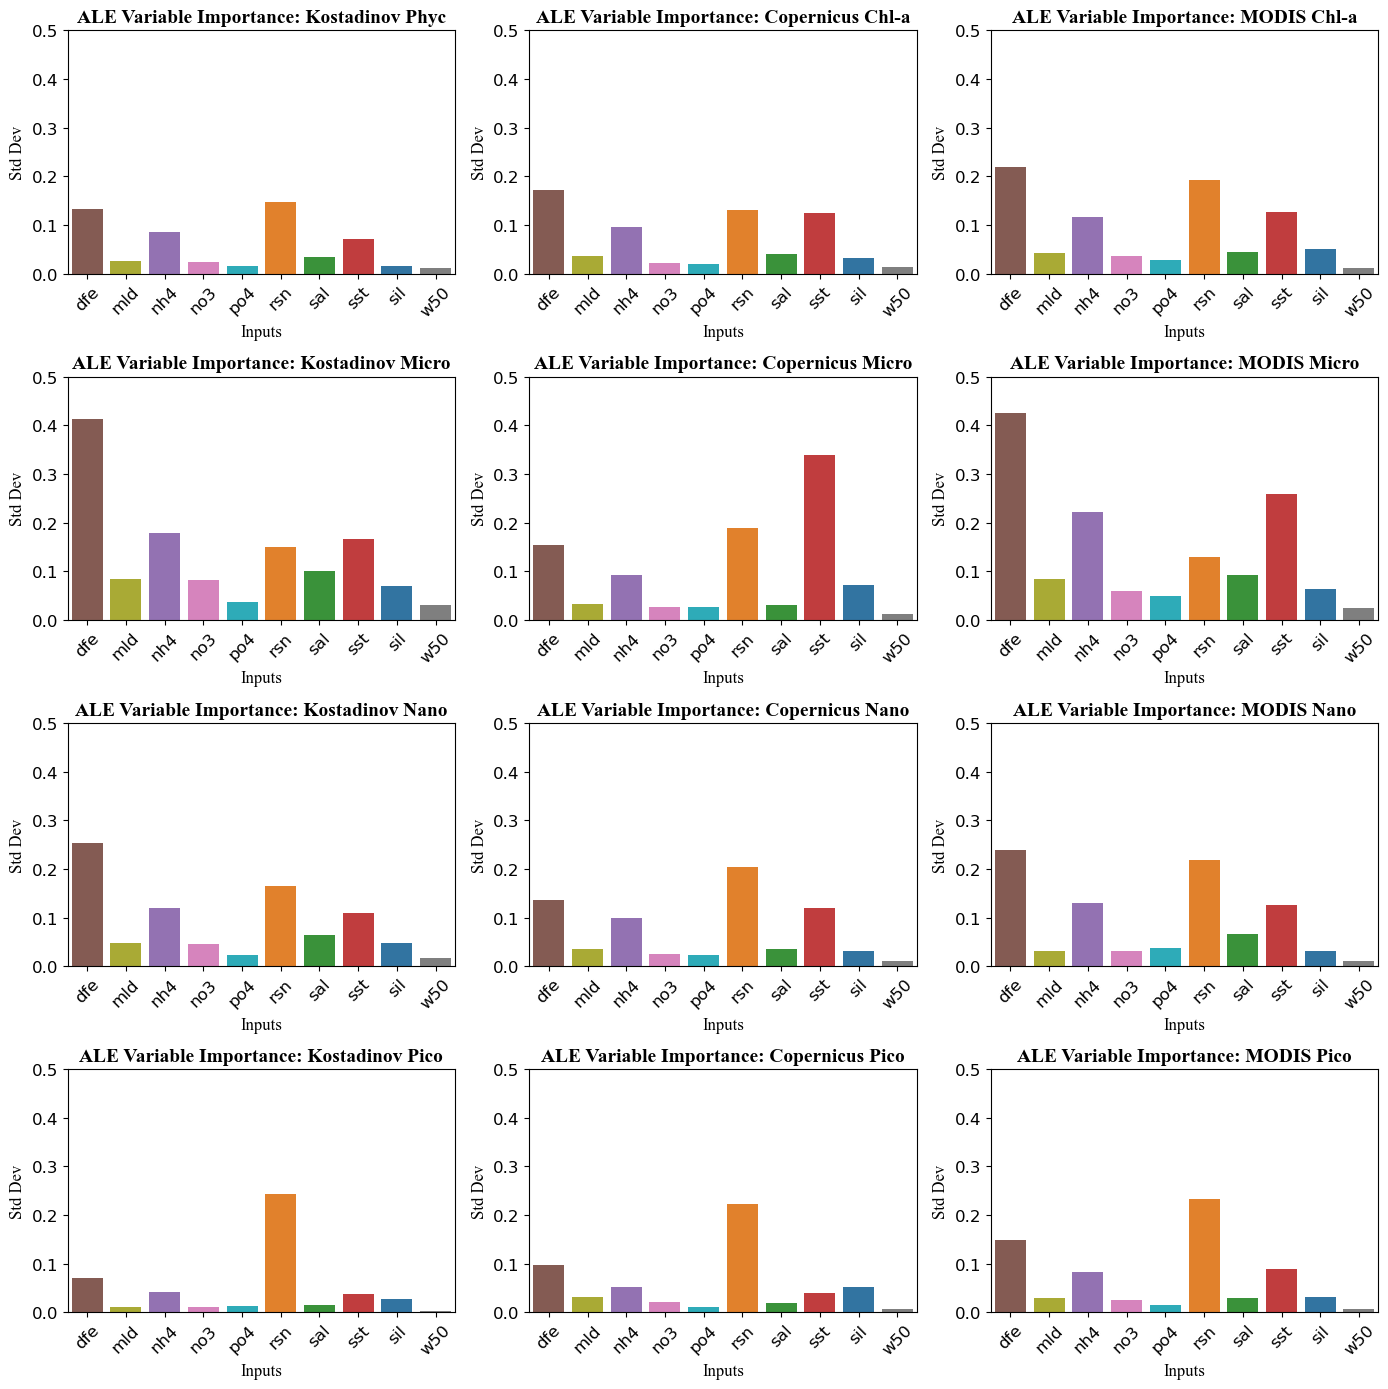

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reset index to get 'Inputs' as a column
phyc_reset = phyc.reset_index().rename(columns={'index': 'Inputs'})
mcro_reset = mcro.reset_index().rename(columns={'index': 'Inputs'})
nano_reset = nano.reset_index().rename(columns={'index': 'Inputs'})
pico_reset = pico.reset_index().rename(columns={'index': 'Inputs'})

# Define datasets and titles
datasets = [
    {'df': phyc_reset, 'y': 'kostaphyc', 'title': 'Kostadinov Phyc'},
    {'df': phyc_reset, 'y': 'coperchla', 'title': 'Copernicus Chl-a'},
    {'df': phyc_reset, 'y': 'modischla', 'title': 'MODIS Chl-a'},
    {'df': mcro_reset, 'y': 'kostamcro', 'title': 'Kostadinov Micro'},
    {'df': mcro_reset, 'y': 'copermcro', 'title': 'Copernicus Micro'},
    {'df': mcro_reset, 'y': 'modismcro', 'title': 'MODIS Micro'},
    {'df': nano_reset, 'y': 'kostanano', 'title': 'Kostadinov Nano'},
    {'df': nano_reset, 'y': 'copernano', 'title': 'Copernicus Nano'},
    {'df': nano_reset, 'y': 'modisnano', 'title': 'MODIS Nano'},
    {'df': pico_reset, 'y': 'kostapico', 'title': 'Kostadinov Pico'},
    {'df': pico_reset, 'y': 'coperpico', 'title': 'Copernicus Pico'},
    {'df': pico_reset, 'y': 'modispico', 'title': 'MODIS Pico'}
]

# Font settings
font = {'family': 'Times New Roman', 'color': 'black', 'fontsize': 14, 'fontweight': 'bold'}
fonttxt = {'family': 'Times New Roman', 'color': 'black', 'fontsize': 12}

# Create subplots (4 rows × 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(14, 14), sharex=False, sharey=False, dpi=100)
axes = axes.flatten()  # Flatten to 1D list for easy iteration

# Plot each dataset
for ax, data in zip(axes, datasets):
    sns.barplot(x='Inputs', y=data['y'], data=data['df'], ax=ax, palette=my_colors, hue='Inputs', legend=False)
    
    ax.set_title(f"ALE Variable Importance: {data['title']}", fontdict=font)
    ax.set_ylabel("Std Dev", fontdict=fonttxt)
    ax.set_ylim([0.0, 0.5])
    ax.set_xlabel("Inputs", fontdict=fonttxt)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.tick_params(axis='x', labelrotation=45)

    
    # Remove legend if present
    if ax.get_legend():
        ax.get_legend().remove()

# Hide any unused axes (in case datasets < total subplots)
for ax in axes[len(datasets):]:
    ax.axis('off')

plt.tight_layout()
fig.savefig(chartpath + "ale_VI_multigroup_scratch.jpg",dpi=200,bbox_inches='tight')
plt.show()